# Botryllus brain analysis1
By: Atefe Rostami

# Packages

In [1]:
import warnings
import random
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import pandas as pd
# import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from igraph import *
import csv
from igraph import *
# from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_text
# import bbknn
# import leidenalg
import seaborn as sns
#from gprofiler import GProfiler

from anndata import AnnData

import plotly.graph_objects as go
import plotly.offline as pyo


In [2]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", mpl.__version__)
print("seaborn version:", sns.__version__)


numpy version: 2.2.6
pandas version: 2.2.3
matplotlib version: 3.10.3
seaborn version: 0.13.2


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Initial data import


In [4]:
# Load the dataset
df = pd.read_csv('Brain_scRNA_Dec_2023_BRAIN_Counts_Table.csv')
df

,GI,Gene_Name,Gene_Note,Aligned_PAC4_Plate3_O06_ILW105_Brain_AB_Zooid_small_3_p09c11r08_6941c_13_19_months_S863.out.counts.txt,Aligned_PAC4_Plate3_M02_ILW104_Brain_AB_Zooid_small_2_p09c05r03_6941c_13_19_months_S797.out.counts.txt,Aligned_PAC4_Plate2_M16_ILW103_Brain_AB_Zooid_large_3_p07c01r06_6941c_13_19_months_S637.out.counts.txt,Aligned_PAC4_Plate2_K15_ILW102_Brain_B2_Zooid_large_2_p07c07r04_6941c_13_19_months_S619.out.counts.txt,Aligned_PAC4_Plate3_G11_ILW106_Brain_AB_Zooid_large_4_p10c11r06_6941c_13_19_months_S935.out.counts.txt,Aligned_PAC4_Plate2_O09_ILW101_Brain_B2_Zooid_large_1_p06c11r04_6941c_1_19_months_S527.out.counts.txt,Aligned_PAC4_Plate3_G08_ILW105_Brain_AB_Zooid_small_3_p10c11r02_6941c_13_19_months_S887.out.counts.txt,...,Aligned_PAC4_Plate2_L11_ILW102_Brain_B2_Zooid_large_2_p06c04r07_6941c_1_19_months_S556.out.counts.txt,Aligned_PAC4_Plate3_B12_ILW106_Brain_AB_Zooid_large_4_p10c10r07_6941c_13_19_months_S946.out.counts.txt,Aligned_PAC4_Plate2_I23_ILW104_Brain_AB_Zooid_small_2_p08c01r07_6941c_13_19_months_S745.out.counts.txt,Aligned_PAC4_Plate2_N07_ILW101_Brain_B2_Zooid_large_1_p06c02r02_6941c_1_19_months_S494.out.counts.txt,Aligned_PAC4_Plate2_L18_ILW103_Brain_AB_Zooid_large_3_p07c08r08_6941c_13_19_months_S668.out.counts.txt,Aligned_PAC4_Plate2_O07_ILW101_Brain_B2_Zooid_large_1_p06c03r02_6941c_1_19_months_S495.out.counts.txt,Aligned_PAC4_Plate2_P04_ILW100_Brain_B2_Zooid_small_1_p05c04r06_6941c_1_19_months_S448.out.counts.txt,Aligned_PAC4_Plate3_N12_ILW106_Brain_AB_Zooid_large_4_p10c10r08_6941c_13_19_months_S958.out.counts.txt,Aligned_PAC4_Plate2_F22_ILW103_Brain_AB_Zooid_large_3_p08c06r05_6941c_13_19_months_S726.out.counts.txt,Aligned_PAC4_Plate3_G14_ILW106_Brain_AB_Zooid_large_4_p11c11r02_6941c_13_19_months_S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72113,__no_feature,NaN,NaN,62,236947,169288,255,350440,2982,35889,...,18741,7537,1104,387400,87939,392462,15597,4041,21610,105402
72114,__ambiguous,NaN,NaN,0,2162,1735,0,3524,16,189,...,110,52,3,1987,795,1812,79,17,199,904
72115,__too_low_aQual,NaN,NaN,0,18,33,0,47,0,1,...,2,2,0,35,14,43,2,0,3,4
72116,__not_aligned,NaN,NaN,17873,330876,256172,48483,586055,9333,292376,...,26679,51094,12786,822342,136587,909838,36070,99680,272789,271757


# Pre_Processing

In [5]:
# Identify metadata columns (first three columns)
metadata_cols = df.columns[:3]
sample_cols = df.columns[3:]

new_column_names = []
for col in sample_cols:
    parts = col.split("_")  # Splitting by "_"

    try:
        sample_id = parts[4]  # ILWXYZ (Sample ID)
        region = parts[6]  # Region (B2, AB)

        # Ensure "19_months" is not split
        if len(parts) > 14 and parts[13].isdigit() and parts[14] == "months":
            age = f"{parts[13]}_{parts[14]}"  # "19_months"
            replicate = parts[10]  # Replicate (pXXcXXrXX)
            sample_number = parts[15]  # Sample Number (SXXX)
        else:
            age = "Unknown"  # If structure doesn't match, label as unknown
            replicate = parts[-3] if len(parts) > 4 else "Unknown"
            sample_number = parts[-2] if len(parts) > 3 else "Unknown"

        # Construct the new column name in the expected format
        new_col_name = f"{sample_id}-{region}-{age}-{replicate}-{sample_number}"
    except IndexError:
        new_col_name = col  # Keep original if unexpected format

    new_column_names.append(new_col_name)

# # rename g_unique column name to Gene_ID
# df.rename(columns={'g_unique': 'Gene_ID'}, inplace=True)
# # Ensure the first three columns are metadata
# metadata_cols = ['Gene_ID', 'Gene_Name', 'Gene_Description'] + list(metadata_cols[3:])
# Rename columns in DataFrame
df.columns = list(metadata_cols) + new_column_names
display(df.head())

,GI,Gene_Name,Gene_Note,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
0,g1,g1,g1|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g10,g10,g10|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,g100,Klhl10,Kelch-like protein 10 [Mus musculus],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,g1000,WDR19,WD repeat-containing protein 19 [Homo sapiens],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g10000,g10000,g10000|introns:1|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filename Structure Reference

 Key Components:
 
- **Plate**: `PAC4_PlateX` (e.g., PAC4_Plate1, PAC4_Plate2)
- **Well**: `A01`, `B02`, `C03`, ... (Position in the plate)
- **Sample ID**: `ILWXYZ` (Unique identifier for the sample)
- **Tissue**: `Brain`
- **Tipe of cell (in time)**: `B2`, `AB` (Specific brain region)
- **Cell Size**: `small`, `large`
- **Replicate**: `pXXcXXrXX` (Pattern: plateX_cellX_repX)
- **Age**: `19_months` (or other time points)
- **Sample Number**: `SXXX` (e.g., S101, S202)



sampleid- region- age-replicate-sample number

## Detecting duplications


In [6]:
# Controlla i valori duplicati nelle colonne specificate
gi_duplicates = df['GI'].duplicated().any()
gene_name_duplicates = df['Gene_Name'].duplicated().any()
gene_note_duplicates = df['Gene_Note'].duplicated().any()

# Risultati
print(f"Duplicati in GI: {gi_duplicates}")
print(f"Duplicati in Gene_Name: {gene_name_duplicates}")
print(f"Duplicati in Gene_Note: {gene_note_duplicates}")

# Opzionalmente, puoi anche stampare i valori duplicati
# if gene_name_duplicates:
#     print("Valori duplicati in Gene_Name:")
#     print(df[df['Gene_Name'].duplicated(keep=False)].sort_values(by='Gene_Name'))


# Creazione della nuova colonna g_unique e metterla come prima colonna
df['g_unique'] = df['GI'].astype(str) + '_' + df['Gene_Name'].astype(str)
cols = df.columns.tolist()
print(cols[-1])
cols = cols[-1:] + cols[:-1]
df = df[cols]

# set GI as index
df.set_index('GI', inplace=True)
# remove "GI", the name of the index
df.index.name = None

# remove the rows which index does not start with "g" (eg. "g1")
df_cleaned = df[df.index.str.startswith('g')]

df_cleaned.tail()


Duplicati in GI: False
Duplicati in Gene_Name: True
Duplicati in Gene_Note: True
g_unique


,g_unique,Gene_Name,Gene_Note,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
g9995,g9995_g9995,g9995,g9995|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9996,g9996_g9996,g9996,g9996|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9997,g9997_g9997,g9997,g9997|introns:2|%transcript_support:20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9998,g9998_WARS,WARS,"Tryptophan--tRNA ligase, cytoplasmic [Homo sa...",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
g9999,g9999_g9999,g9999,g9999|introns:0|%transcript_support:0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_cleaned.columns
# save a new df without Gene_Note and Gene_Name columns
df_sel = df_cleaned.drop(['Gene_Note', 'Gene_Name'], axis=1)

df_sel.set_index('g_unique', inplace=True)
df_sel.index.name = None

df_sel.tail()

,ILW105-AB-19_months-p09c11r08-S863.out.counts.txt,ILW104-AB-19_months-p09c05r03-S797.out.counts.txt,ILW103-AB-19_months-p07c01r06-S637.out.counts.txt,ILW102-B2-19_months-p07c07r04-S619.out.counts.txt,ILW106-AB-19_months-p10c11r06-S935.out.counts.txt,ILW101-B2-19_months-p06c11r04-S527.out.counts.txt,ILW105-AB-19_months-p10c11r02-S887.out.counts.txt,ILW103-AB-19_months-p07c06r07-S654.out.counts.txt,ILW106-AB-19_months-p11c12r04-S1008.out.counts.txt,ILW101-B2-19_months-p06c09r01-S489.out.counts.txt,...,ILW102-B2-19_months-p06c04r07-S556.out.counts.txt,ILW106-AB-19_months-p10c10r07-S946.out.counts.txt,ILW104-AB-19_months-p08c01r07-S745.out.counts.txt,ILW101-B2-19_months-p06c02r02-S494.out.counts.txt,ILW103-AB-19_months-p07c08r08-S668.out.counts.txt,ILW101-B2-19_months-p06c03r02-S495.out.counts.txt,ILW100-B2-19_months-p05c04r06-S448.out.counts.txt,ILW106-AB-19_months-p10c10r08-S958.out.counts.txt,ILW103-AB-19_months-p08c06r05-S726.out.counts.txt,ILW106-AB-19_months-p11c11r02-S983.out.counts.txt
g9995_g9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9996_g9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9997_g9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9998_WARS,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
g9999_g9999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# print the removed rows
print("Removed rows:")
df_removed = df[~df.index.str.startswith('g')]
df_removed.index

Removed rows:


Index(['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned',
       '__alignment_not_unique'],
      dtype='object')

**df_sel** is the cleaned input dataset. Ready for more processing

## AnnData

In [9]:
# adata = AnnData(df_sel)
# Transpose the DataFrame to have genes as rows and cells as columns
# obs is the cell/sample IDs
# var is the gene IDs/names
adata = AnnData(X=df_sel.T.values, obs=pd.DataFrame(index=df_sel.columns), var=pd.DataFrame(index=df_sel.index))

# print first 4 row names and first 4 column names
print(adata.obs_names[:4])  # First 4 cell/sample IDs
print(adata.var_names[:4])  # First 4 gene IDs/names
print(adata.shape)          # Shape: (cells, genes)


Index(['ILW105-AB-19_months-p09c11r08-S863.out.counts.txt',
       'ILW104-AB-19_months-p09c05r03-S797.out.counts.txt',
       'ILW103-AB-19_months-p07c01r06-S637.out.counts.txt',
       'ILW102-B2-19_months-p07c07r04-S619.out.counts.txt'],
      dtype='object')
Index(['g1_g1', 'g10_g10', 'g100_Klhl10', 'g1000_WDR19'], dtype='object')
(683, 72113)


In [10]:
import scipy.sparse

print(type(adata.X))

# Or check if it's sparse
if scipy.sparse.issparse(adata.X):
    print("adata.X is a sparse matrix.")
else:
    print("adata.X is a dense NumPy array.")


<class 'numpy.ndarray'>
adata.X is a dense NumPy array.


adata.X is your expression matrix (cells × genes).

.sum(axis=1) sums counts across all genes for each cell, giving the total counts per cell.


In [11]:
# Parse sample metadata from cell/sample names and store as separate columns in adata.obs
# Extracts Sample_ID, Region, Age, Replicate, and Sample_Number from the sample name string
adata.obs['Sample_ID'] = [i.split('-')[0] for i in adata.obs_names] 
adata.obs['Region'] =    [i.split('-')[1] for i in adata.obs_names]
adata.obs['Age'] =       [i.split('-')[2] for i in adata.obs_names]
adata.obs['Replicate'] = [i.split('-')[3] for i in adata.obs_names]
adata.obs['Sample_Number'] = [i.split('-')[4] for i in adata.obs_names]

print(adata.shape)


(683, 72113)


**Check** the format of the matrix

In [12]:
# Sum along the columns (genes)
# adata.X is a sparse matrix, so we need to convert it to a dense format first
total_counts = adata.X.sum(axis=1)
print(total_counts.shape)

(683,)


## Quality control

In [13]:
import scanpy as sc  # Ensure scanpy is imported

# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1) # total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(1) # number of expressed genes per cell
adata = adata[adata.obs['n_counts']>=100]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



In [14]:
print(adata.obs.shape)

(573, 7)


In [15]:
# Zeros fraction
zeros_perGene_frac = np.sum(adata.X == 0, axis=0) / adata.X.shape[0]

genes_above = zeros_perGene_frac[zeros_perGene_frac > 0.95]
num_genes_above = len(genes_above)/adata.X.shape[1]
print("Number of genes with a fraction of zeros above :", num_genes_above)

# plt.figure(figsize=(6,3))
# sns.histplot(zeros_perGene_frac, bins=80, color='skyblue', stat='density')
# plt.xlim(0.85,1)



Number of genes with a fraction of zeros above : 0.4985240906494001


In [16]:
print(adata.shape)

(573, 21004)


# Normalization

## LogNorm

It adjusts for sequencing depth differences across cells — like converting all cells to the same "library size."

Think of it like converting raw counts to counts per 10,000 (CP10K), similar to CPM (counts per million).

In [17]:
# Step 1: Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Logarithmize the data log(x+1)
sc.pp.log1p(adata)



# PCA

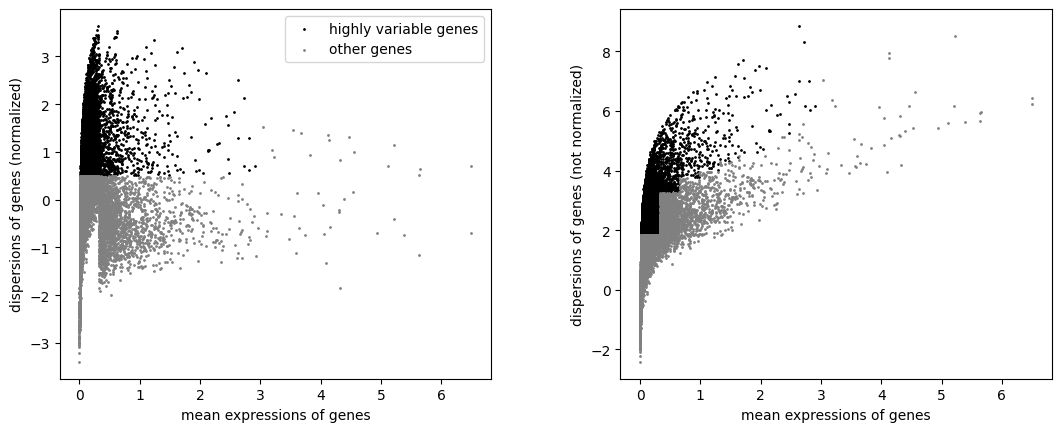

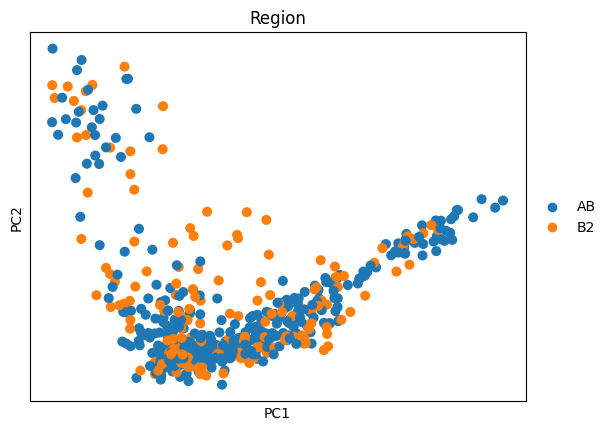

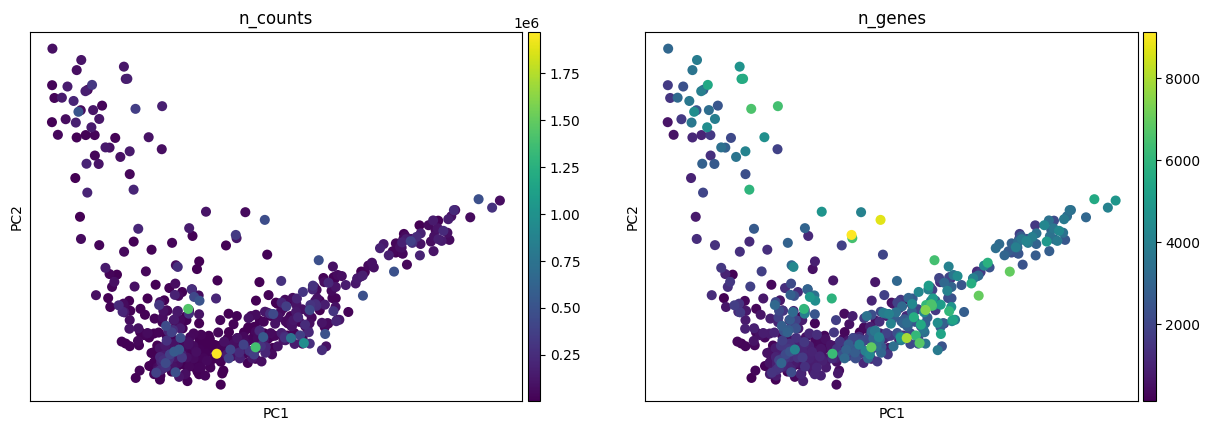

In [18]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

# Run PCA using HVGs
sc.tl.pca(adata, svd_solver = 'arpack', use_highly_variable=True)

# Plot PCA
sc.pl.pca(adata, color=['Region'])

# Plot PCA with n_counts and n_genes
sc.pl.pca_scatter(adata, color=['n_counts', 'n_genes'])

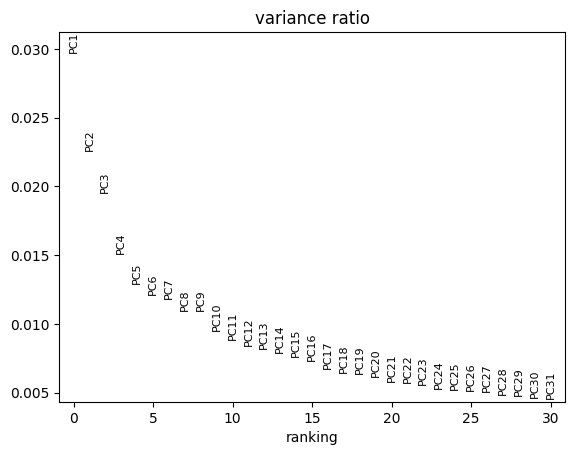

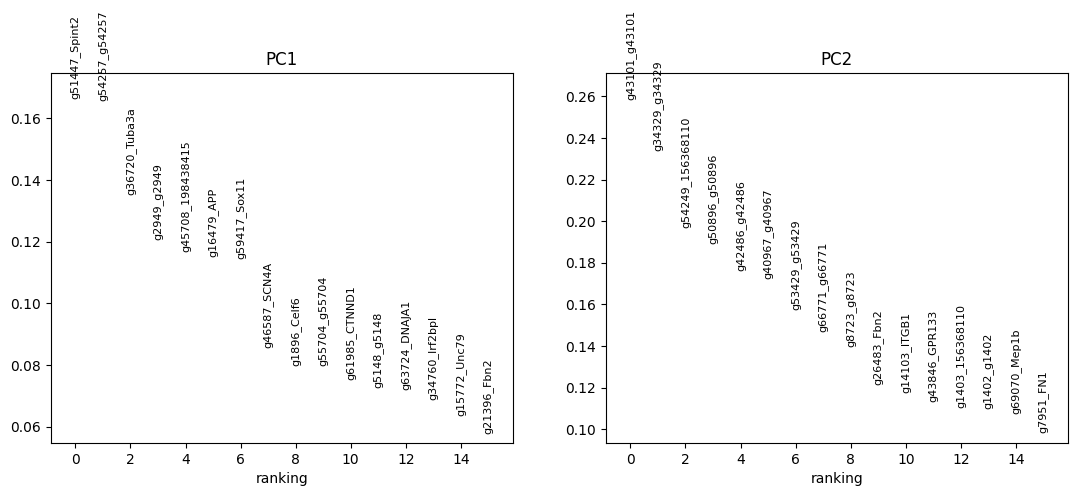

In [19]:
# pca variance ratio
sc.pl.pca_variance_ratio(adata, log=False)

# PCA loadings (genes contributing to PCs)
sc.pl.pca_loadings(adata, components='1,2', show=False, include_lowest=False, n_points=15)

# Dimensionality Reduction UMAP


## umap(nn=25,npcs=5,metrics=cosine)

For each cell, look at the first 6 PCA dimensions, and find the 25 most similar cells using cosine distance.

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



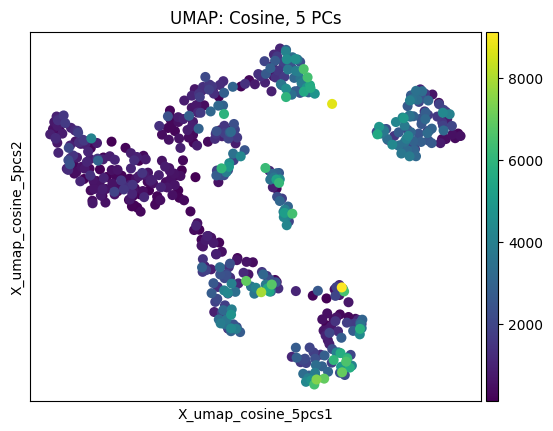

In [20]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='cosine')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_cosine_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph
adata.uns['neighbors_cosine_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_cosine_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_cosine_5pcs'] = adata.obsp['distances'].copy()

# Plot it
sc.pl.embedding(adata, basis='X_umap_cosine_5pcs', color='n_genes', title='UMAP: Cosine, 5 PCs')

## umap(nn=25,npcs=5,metrics=euclidean)

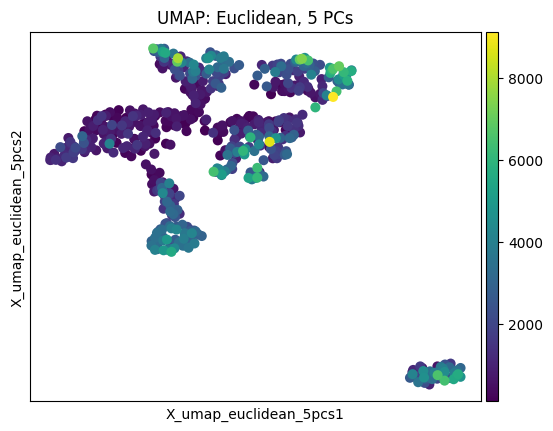

In [21]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=5, random_state=0, metric='euclidean')
sc.tl.umap(adata)

# Save UMAP coordinates
adata.obsm['X_umap_euclidean_5pcs'] = adata.obsm['X_umap'].copy()

# Save neighbor graph (optional but useful)
adata.uns['neighbors_euclidean_5pcs'] = adata.uns['neighbors']
adata.obsp['connectivities_euclidean_5pcs'] = adata.obsp['connectivities'].copy()
adata.obsp['distances_euclidean_5pcs'] = adata.obsp['distances'].copy()

# Plot UMAP
sc.pl.embedding(adata, basis='X_umap_euclidean_5pcs', color='n_genes', title='UMAP: Euclidean, 5 PCs')



In [20]:
# # Restore cosine neighbors if you want to cluster using that graph again
# adata.uns['neighbors'] = adata.uns['neighbors_cosine_6pcs']
# adata.obsp['connectivities'] = adata.obsp['connectivities_cosine_6pcs']
# adata.obsp['distances'] = adata.obsp['distances_cosine_6pcs']

# # Then you can run clustering (e.g. Leiden)
# sc.tl.leiden(adata, resolution=0.5)
# sc.pl.embedding(adata, basis='X_umap_cosine_6pcs', color='leiden')


## Save UMAP

In [21]:
# adata.write('my_analysis_with_multiple_umaps.h5ad')

# Clustering (Leiden and DBSCAN) 

The two best parameters for each umap is defined in the code

In [22]:
import scanpy as sc
from sklearn.cluster import DBSCAN

def run_umap_and_cluster(
    adata,
    nn,
    npcs,
    metric,
    leiden_resolution,
    dbscan_eps,
    dbscan_min_samples
):
    # Step 1: Compute neighbors
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=npcs, metric=metric, random_state=0)
    
    # Step 2: Compute UMAP
    sc.tl.umap(adata)
    
    # Save UMAP embedding with flag in obsm
    umap_key = f'X_umap_nn{nn}_pcs{npcs}_{metric}'
    adata.obsm[umap_key] = adata.obsm['X_umap'].copy()
    
    # Step 3: Leiden clustering
    leiden_key = f'leiden_res{leiden_resolution}_nn{nn}_pcs{npcs}_{metric}'
    sc.tl.leiden(adata, resolution=leiden_resolution, key_added=leiden_key)
    
    # Step 4: DBSCAN clustering on the UMAP embedding
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric=metric)
    dbscan_labels = dbscan.fit_predict(adata.obsm[umap_key])
    dbscan_key = f'dbscan_eps{dbscan_eps}_min{dbscan_min_samples}_nn{nn}_pcs{npcs}_{metric}'
    adata.obs[dbscan_key] = dbscan_labels.astype(str)
    
    # Return keys for later use
    return {
        'umap_key': umap_key,
        'leiden_key': leiden_key,
        'dbscan_key': dbscan_key
    }


## Heatmap

In [23]:
# clusterings = [
#     'leiden_res0.5_nn25_pcs5_cosine',
#     #'leiden_res0.5_nn25_pcs5_euclidean'
# ]

# for clust_key in clusterings:
#     print(f"\nProcessing clustering: {clust_key}")
    
#     # Rank genes per cluster (Wilcoxon)
#     sc.tl.rank_genes_groups(
#         adata,
#         groupby=clust_key,
#         method='wilcoxon',
#         tie_correct=True,
#         pts=True,
#         key_added=f'wilcoxon_{clust_key}'
#     )
    
#     # Plot heatmap of top 20 marker genes
#     sc.pl.rank_genes_groups_heatmap(
#         adata,
#         n_genes=20,
#         groupby=clust_key,
#         key=f'wilcoxon_{clust_key}',
#         show=True
#     )


In [23]:
results_cosine = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=5,
    metric='cosine',
    leiden_resolution=0.58,
    dbscan_eps=0.0002,
    dbscan_min_samples=10
)

results_euclidean = run_umap_and_cluster(
    adata,
    nn=25,
    npcs=5,
    metric='euclidean',
    leiden_resolution=0.58,
    dbscan_eps=0.65,
    dbscan_min_samples=10
)


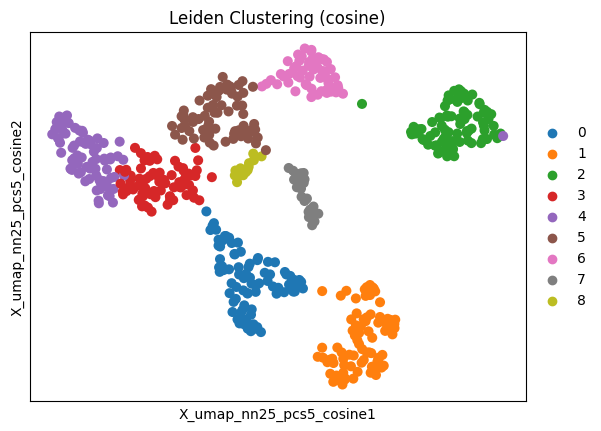

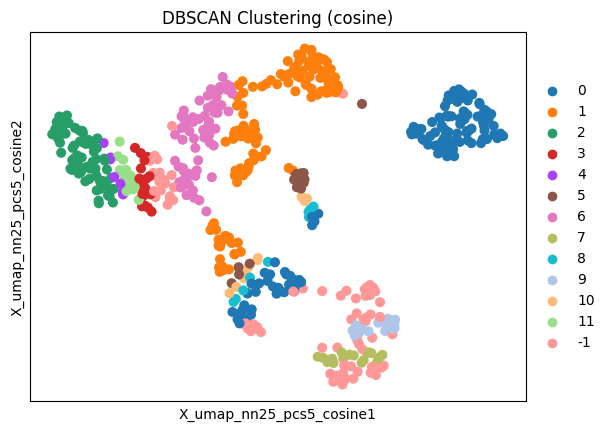

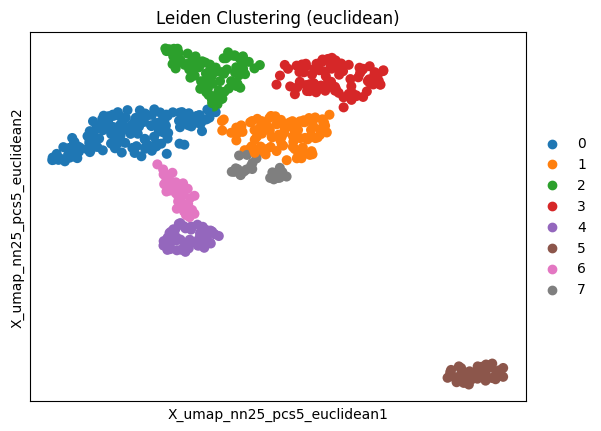

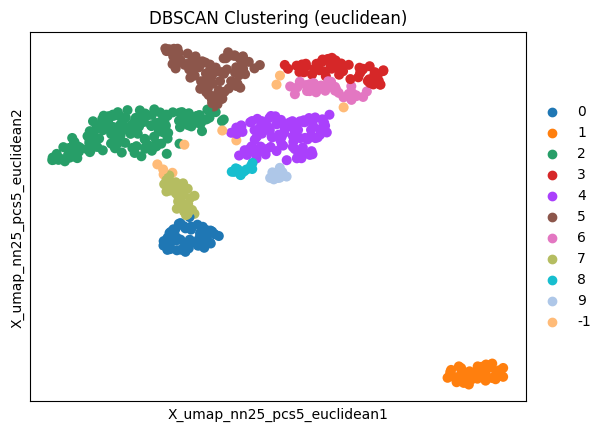

In [24]:
# Plot UMAP colored by Leiden for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['leiden_key'], title='Leiden Clustering (cosine)')

# Plot UMAP colored by DBSCAN for cosine
sc.pl.embedding(adata, basis=results_cosine['umap_key'], color=results_cosine['dbscan_key'], title='DBSCAN Clustering (cosine)')

# Plot UMAP colored by Leiden for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['leiden_key'], title='Leiden Clustering (euclidean)')

# Plot UMAP colored by DBSCAN for euclidean
sc.pl.embedding(adata, basis=results_euclidean['umap_key'], color=results_euclidean['dbscan_key'], title='DBSCAN Clustering (euclidean)')


# Marker gene finding

## Finding the marker genes in each cluster

In [25]:
def extract_suffix(s):
    parts = s.split('_')
    return parts[1] if len(parts) > 1 else s

In [26]:
# Display list of Leiden and DBSCAN cluster keys in adata.obs
leiden_keys = [col for col in adata.obs.columns if col.startswith('leiden_res')]
dbscan_keys = [col for col in adata.obs.columns if col.startswith('dbscan_eps')]

print("Leiden cluster keys:", leiden_keys)
print("DBSCAN cluster keys:", dbscan_keys)


Leiden cluster keys: ['leiden_res0.58_nn25_pcs5_cosine', 'leiden_res0.58_nn25_pcs5_euclidean']
DBSCAN cluster keys: ['dbscan_eps0.0002_min10_nn25_pcs5_cosine', 'dbscan_eps0.65_min10_nn25_pcs5_euclidean']


In [27]:
# Toggle which clustering results you want to process
# Just comment out the ones you don't want

cluster_keys = [
  'leiden_res0.58_nn25_pcs5_cosine',
  'dbscan_eps0.0002_min10_nn25_pcs5_cosine',
  'leiden_res0.58_nn25_pcs5_euclidean',
  'dbscan_eps0.65_min10_nn25_pcs5_euclidean'
]

In [28]:
X = adata.obsm['X_pca']  # if you have PCA computed

# Calculate clustering quality metrics

In [29]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
for key in cluster_keys:
    labels = adata.obs[key].values
    # Silhouette
    sil_score = silhouette_score(X, labels)
    # Calinski-Harabasz
    ch_score = calinski_harabasz_score(X, labels)
    # Davies-Bouldin
    db_score = davies_bouldin_score(X, labels)
    print(f"{key}: Silhouette={sil_score:.3f}, Calinski-Harabasz={ch_score:.3f}, Davies-Bouldin={db_score:.3f}")

leiden_res0.58_nn25_pcs5_cosine: Silhouette=0.038, Calinski-Harabasz=24.053, Davies-Bouldin=2.746
dbscan_eps0.0002_min10_nn25_pcs5_cosine: Silhouette=-0.092, Calinski-Harabasz=9.594, Davies-Bouldin=3.648
leiden_res0.58_nn25_pcs5_euclidean: Silhouette=0.108, Calinski-Harabasz=26.480, Davies-Bouldin=2.633
dbscan_eps0.65_min10_nn25_pcs5_euclidean: Silhouette=0.038, Calinski-Harabasz=21.630, Davies-Bouldin=2.603


## Clustering Quality Metrics Interpretation

We evaluated four clustering methods using three common internal quality metrics:

| Clustering Method                         | Silhouette Score | Calinski-Harabasz Index | Davies-Bouldin Index |
|------------------------------------------|------------------|------------------------|---------------------|
| leiden_res0.58_nn25_pcs5_cosine          | 0.038            | 24.053                 | 2.746               |
| dbscan_eps0.0002_min10_nn25_pcs5_cosine  | -0.092           | 9.594                  | 3.648               |
| leiden_res0.58_nn25_pcs5_euclidean       | 0.108            | 26.480                 | 2.633               |
| dbscan_eps0.65_min10_nn25_pcs5_euclidean | 0.038            | 21.630                 | 2.603               |

### Interpretation:

- **Silhouette Score** (range: -1 to 1; higher is better):  
  Measures how well-separated the clusters are.  
  - The Leiden method (`leiden_res0.58_nn25_pcs5_cosine` and `leiden_res0.58_nn25_pcs5_euclidean`) has moderate silhouette scores (0.038 and 0.108, respectively), indicating that the clusters are not very well-separated but still perform better than DBSCAN methods.
  - The DBSCAN methods (`dbscan_eps0.0002_min10_nn25_pcs5_cosine` and `dbscan_eps0.65_min10_nn25_pcs5_euclidean`) have very low silhouette scores, with the former having a negative score (-0.092). This suggests poor clustering, with significant overlap between clusters, especially for the `dbscan_eps0.0002_min10_nn25_pcs5_cosine` method.

- **Calinski-Harabasz Index** (higher is better):  
  Indicates how compact and well-separated the clusters are based on variance ratios.  
  - The Leiden method with Euclidean distance (`leiden_res0.58_nn25_pcs5_euclidean`) scores the highest at 26.480, indicating that it produces more compact and well-separated clusters.
  - DBSCAN methods, especially with lower `eps` values like `dbscan_eps0.0002_min10_nn25_pcs5_cosine`, score much lower (9.594), indicating that the clusters are less compact and more dispersed.

- **Davies-Bouldin Index** (lower is better):  
  Measures the average similarity between clusters; lower values mean less overlap.  
  - The Leiden method with Euclidean distance (`leiden_res0.58_nn25_pcs5_euclidean`) has the lowest Davies-Bouldin score (2.633), indicating that the clusters are more distinct and have less overlap.
  - The DBSCAN method with the lowest `eps` value (`dbscan_eps0.0002_min10_nn25_pcs5_cosine`) has the highest Davies-Bouldin score (3.648), indicating poor clustering with significant overlap between clusters.

### Summary:

Among the clustering methods, **Leiden clustering** (especially with **Euclidean distance**) consistently outperforms **DBSCAN** on all three metrics. The **Leiden** methods produce more distinct, compact, and well-separated clusters, with higher **Silhouette** and **Calinski-Harabasz** scores and a lower **Davies-Bouldin** score.

In contrast, the **DBSCAN** methods perform poorly, particularly the one with `eps=0.0002`, which produces fragmented clusters and has the lowest performance across all metrics, as indicated by a **negative Silhouette** score. Even with a higher `eps` value (`dbscan_eps0.65_min10_nn25_pcs5_euclidean`), DBSCAN still performs worse than Leiden clustering.

Thus, **Leiden** with **Euclidean distance** (`leiden_res0.58_nn25_pcs5_euclidean`) emerges as the best-performing method based on the clustering quality metrics.


# Compare clusterings using ARI and NMI

In [30]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
keys = cluster_keys  # list of cluster label columns in adata.obs

for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        labels1 = adata.obs[keys[i]].values
        labels2 = adata.obs[keys[j]].values
        ari = adjusted_rand_score(labels1, labels2)
        nmi = normalized_mutual_info_score(labels1, labels2)
        print(f"ARI between {keys[i]} and {keys[j]}: {ari:.3f}")
        print(f"NMI between {keys[i]} and {keys[j]}: {nmi:.3f}")

ARI between leiden_res0.58_nn25_pcs5_cosine and dbscan_eps0.0002_min10_nn25_pcs5_cosine: 0.455
NMI between leiden_res0.58_nn25_pcs5_cosine and dbscan_eps0.0002_min10_nn25_pcs5_cosine: 0.636
ARI between leiden_res0.58_nn25_pcs5_cosine and leiden_res0.58_nn25_pcs5_euclidean: 0.732
NMI between leiden_res0.58_nn25_pcs5_cosine and leiden_res0.58_nn25_pcs5_euclidean: 0.854
ARI between leiden_res0.58_nn25_pcs5_cosine and dbscan_eps0.65_min10_nn25_pcs5_euclidean: 0.676
NMI between leiden_res0.58_nn25_pcs5_cosine and dbscan_eps0.65_min10_nn25_pcs5_euclidean: 0.822
ARI between dbscan_eps0.0002_min10_nn25_pcs5_cosine and leiden_res0.58_nn25_pcs5_euclidean: 0.314
NMI between dbscan_eps0.0002_min10_nn25_pcs5_cosine and leiden_res0.58_nn25_pcs5_euclidean: 0.566
ARI between dbscan_eps0.0002_min10_nn25_pcs5_cosine and dbscan_eps0.65_min10_nn25_pcs5_euclidean: 0.292
NMI between dbscan_eps0.0002_min10_nn25_pcs5_cosine and dbscan_eps0.65_min10_nn25_pcs5_euclidean: 0.556
ARI between leiden_res0.58_nn25_pc

## Cluster Label Agreement Between Methods

We compared the clustering assignments pairwise using two metrics:

- **Adjusted Rand Index (ARI):**  
  Measures similarity between two clusterings, adjusted for chance.  
  Values range from -1 to 1, where 1 means perfect agreement and 0 indicates random similarity.

- **Normalized Mutual Information (NMI):**  
  Measures shared information between clusterings.  
  Values range from 0 to 1, where 1 means identical clusterings.

| Cluster Pair                                                   | ARI   | NMI   |
|---------------------------------------------------------------|-------|-------|
| leiden_res0.58_nn25_pcs5_cosine vs dbscan_eps0.0002_min10_nn25_pcs5_cosine | 0.455 | 0.636 |
| leiden_res0.58_nn25_pcs5_cosine vs leiden_res0.58_nn25_pcs5_euclidean | 0.732 | 0.854 |
| leiden_res0.58_nn25_pcs5_cosine vs dbscan_eps0.65_min10_nn25_pcs5_euclidean | 0.676 | 0.822 |
| dbscan_eps0.0002_min10_nn25_pcs5_cosine vs leiden_res0.58_nn25_pcs5_euclidean | 0.314 | 0.566 |
| dbscan_eps0.0002_min10_nn25_pcs5_cosine vs dbscan_eps0.65_min10_nn25_pcs5_euclidean | 0.292 | 0.556 |
| leiden_res0.58_nn25_pcs5_euclidean vs dbscan_eps0.65_min10_nn25_pcs5_euclidean | 0.921 | 0.924 |

### Interpretation:

- The **highest agreement** is between **leiden_res0.58_nn25_pcs5_euclidean and dbscan_eps0.65_min10_nn25_pcs5_euclidean** (ARI = 0.921, NMI = 0.924), suggesting these two methods produce very similar cluster assignments.

- The **Leiden methods** (`leiden_res0.58_nn25_pcs5_cosine` vs `leiden_res0.58_nn25_pcs5_euclidean`) show **high agreement** (ARI = 0.732, NMI = 0.854), indicating that different distance metrics (Cosine vs Euclidean) in Leiden still produce similar cluster assignments.

- **Leiden and DBSCAN** methods show **moderate to low agreement** in some pairs:
  - `leiden_res0.58_nn25_pcs5_cosine` vs `dbscan_eps0.0002_min10_nn25_pcs5_cosine` has moderate agreement (ARI = 0.455, NMI = 0.636), suggesting that the cosine-based Leiden and DBSCAN methods are somewhat aligned, but still differ.
  - `leiden_res0.58_nn25_pcs5_cosine` vs `dbscan_eps0.65_min10_nn25_pcs5_euclidean` (ARI = 0.676, NMI = 0.822) shows a higher agreement than between `leiden_res0.58_nn25_pcs5_cosine` and `dbscan_eps0.0002_min10_nn25_pcs5_cosine`, indicating that the combination of DBSCAN with higher `eps` (0.65) and Euclidean distance is somewhat more aligned with Leiden results.

- The **lowest agreement** is found between the DBSCAN methods with extreme `eps` values (`dbscan_eps0.0002_min10_nn25_pcs5_cosine` and `dbscan_eps0.65_min10_nn25_pcs5_euclidean`), which shows the **weakest similarity** (ARI = 0.292, NMI = 0.556). This indicates that varying the `eps` parameter in DBSCAN significantly affects the clustering outcomes, leading to less overlap in cluster assignments.

### Summary:

The agreement analysis shows that the **Leiden methods** consistently exhibit **high agreement** with each other, regardless of whether Cosine or Euclidean distance is used. The highest agreement is found when comparing **Leiden (Euclidean)** with **DBSCAN (Euclidean, eps=0.65)**, suggesting that combining a more permissive DBSCAN (`eps=0.65`) with Euclidean distance produces results that are closely aligned with Leiden's clustering.

However, **DBSCAN with very low `eps` (0.0002)** results in much **lower agreement** with Leiden and other DBSCAN configurations, highlighting that a stricter clustering threshold might cause DBSCAN to identify fewer or more fragmented clusters.

Overall, the Leiden methods show more consistent clustering results, while DBSCAN's performance is more sensitive to its parameter settings. The results suggest focusing on Leiden methods for more stable and reproducible clustering assignments, with DBSCAN being useful when experimenting with different density-based clustering configurations.


# Cell distribution among clusters

In [31]:
# Toggle which clustering results you want to process
# Just comment out the ones you don't want

cluster_keys = [
   'leiden_res0.58_nn25_pcs5_cosine',
#   'dbscan_eps0.0002_min10_nn25_pcs5_cosine',
#   'leiden_res0.58_nn25_pcs5_euclidean',
#  'dbscan_eps0.65_min10_nn25_pcs5_euclidean'
]


Processing clustering: leiden_res0.58_nn25_pcs5_cosine
Number of cells in each cluster for leiden_res0.58_nn25_pcs5_cosine:
leiden_res0.58_nn25_pcs5_cosine
0    87
1    85
2    85
3    77
4    77
5    70
6    53
7    25
8    14
Name: count, dtype: int64


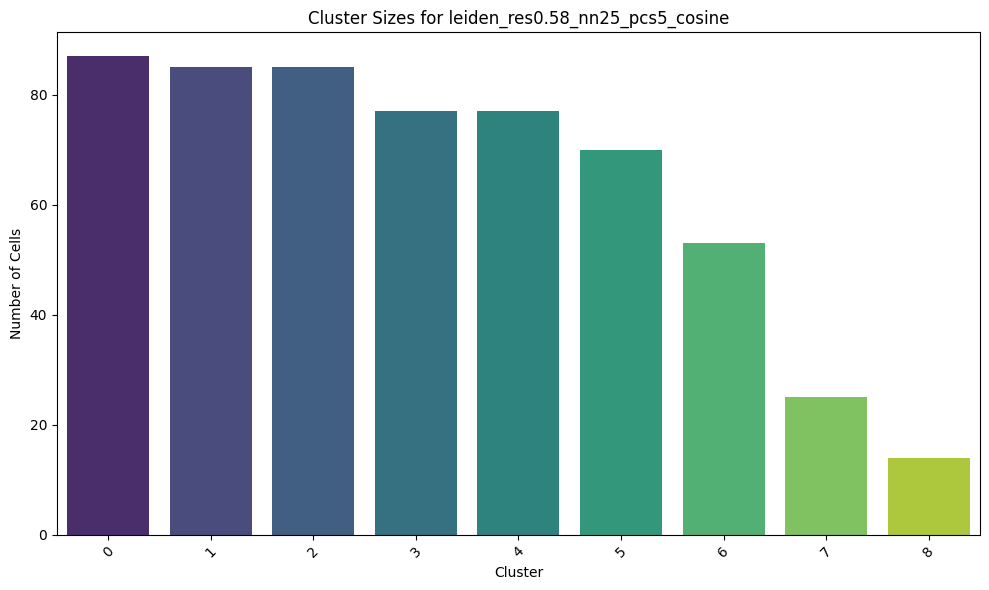

In [32]:
# number of cells in each cluster in each cluster_key leiden_res0.58_nn25_pcs5_cosine
for clust_key in cluster_keys:
    print(f"\nProcessing clustering: {clust_key}")
    
    # Use the full clustering key as the column name
    leiden_key = clust_key
    
    # Get the unique clusters
    unique_clusters = adata.obs[leiden_key].unique()
    
    # Count cells in each cluster
    cluster_counts = adata.obs[leiden_key].value_counts()
    
    print(f"Number of cells in each cluster for {clust_key}:")
    print(cluster_counts)
    
    # Plot bar chart of cluster sizes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
    plt.title(f'Cluster Sizes for {clust_key}')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Cells')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [33]:
# === FLAGS ===
RUN_RANKING = True
SAVE_CSV = True
TOP_N = None   # Set to None to disable top-N trimming
PRINT_PREVIEW = True

# === Loop through your clustering keys ===
for cluster_key in cluster_keys:
    print(f"\nProcessing: {cluster_key}")
    
    marker_key = f'wilcoxon_{cluster_key}'
    
    if RUN_RANKING:
        # Run Wilcoxon ranking
        sc.tl.rank_genes_groups(
            adata,
            groupby=cluster_key,
            method='wilcoxon',
            tie_correct=True,
            pts=True,
            key_added=marker_key
        )
    
    # Extract results
    result = adata.uns[marker_key]
    groups = result['names'].dtype.names  # cluster names

    # Collect marker genes per cluster (optionally trim to top N)
    marker_df = pd.concat([
        pd.DataFrame({
            'cluster': group,
            'gene': result['names'][group][:TOP_N] if TOP_N else result['names'][group],
            'score': result['scores'][group][:TOP_N] if TOP_N else result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group][:TOP_N] if TOP_N else result['logfoldchanges'][group],
            'pval': result['pvals'][group][:TOP_N] if TOP_N else result['pvals'][group],
            'pval_adj': result['pvals_adj'][group][:TOP_N] if TOP_N else result['pvals_adj'][group],
            'pct_expr': result['pts'][group][:TOP_N] if TOP_N else result['pts'][group]
        })
        for group in groups
    ])

    # # Save to CSV if enabled
    # if SAVE_CSV:
    #     filename = f'top{TOP_N if TOP_N else "all"}_marker_genes_{cluster_key}.csv'
    #     marker_df.to_csv(filename, index=False)
    #     print(f"Saved: {filename}")
    
    # Print preview if enabled
    if PRINT_PREVIEW:
        print(marker_df.head())



Processing: leiden_res0.58_nn25_pcs5_cosine
               cluster              gene      score  logfoldchange  \
g1_g1                0      g70168_Spon1  15.316243       6.837347   
g1000_WDR19          0  g27566_313244217  15.266523       5.067207   
g10003_Tspan13       0  g55902_198437168  15.208722       4.924525   
g10006_Xrn1          0     g54534_g54534  14.938223       4.931764   
g10007_g10007        0       g1895_g1895  14.761584       5.540333   

                        pval      pval_adj  pct_expr  
g1_g1           5.956209e-53  1.251042e-48  0.057471  
g1000_WDR19     1.278082e-52  1.342242e-48  0.011494  
g10003_Tspan13  3.095256e-52  2.167092e-48  0.413793  
g10006_Xrn1     1.858659e-50  9.759818e-47  0.057471  
g10007_g10007   2.591222e-49  1.088520e-45  0.068966  


In [34]:
for cluster_key in cluster_keys:
    print(f"\nProcessing: {cluster_key}")
    
    marker_key = f'wilcoxon_{cluster_key}'
    
    # Rank genes using Wilcoxon test
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method='wilcoxon',
        tie_correct=True,
        pts=True,
        key_added=marker_key
    )
    
    # Extract full result: names, scores, logfoldchanges, pvals, etc.
    result = adata.uns[marker_key]
    groups = result['names'].dtype.names  # cluster names

    full_marker_df = pd.concat([
        pd.DataFrame({
            'cluster': group,
            'gene': result['names'][group],
            'score': result['scores'][group],
            'logfoldchange': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'pct_expr': result['pts'][group]
        })
        for group in groups
    ])

    # Save to CSV
    filename = f'marker_genes_{cluster_key}.csv'
    full_marker_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")



Processing: leiden_res0.58_nn25_pcs5_cosine
Saved: marker_genes_leiden_res0.58_nn25_pcs5_cosine.csv


In [35]:
full_marker_df.head(20)

,cluster,gene,score,logfoldchange,pval,pval_adj,pct_expr
g1_g1,0,g70168_Spon1,15.316243,6.837347,5.956209e-53,1.251042e-48,0.057471
g1000_WDR19,0,g27566_313244217,15.266523,5.067207,1.278082e-52,1.342242e-48,0.011494
g10003_Tspan13,0,g55902_198437168,15.208722,4.924525,3.095256e-52,2.167092e-48,0.413793
g10006_Xrn1,0,g54534_g54534,14.938223,4.931764,1.858659e-50,9.759818e-47,0.057471
g10007_g10007,0,g1895_g1895,14.761584,5.540333,2.591222e-49,1.088520e-45,0.068966
g1001_g1001,0,g20107_g20107,14.435874,5.002803,3.077184e-47,1.046847e-43,0.034483
g10011_g10011,0,g11265_Mep1b,14.427216,5.520316,3.488824e-47,1.046847e-43,0.000000
g10012_Lrrc56,0,g20108_g20108,14.324404,4.597886,1.540455e-46,4.044463e-43,0.011494
g10015_FCN1,0,g21396_Fbn2,14.082177,4.588856,4.888009e-45,1.140753e-41,0.022989
g10018_ABCB7,0,g14414_g14414,13.827270,5.556118,1.745195e-43,3.665607e-40,0.022989


## Finding the marker genes (Only annotated markers)

In [36]:
# Clean the gene column in full_marker_df by splitting it by "_" and selecting the second part and the third part if it exists
full_marker_df['gene'] = full_marker_df['gene'].apply(
    lambda x: '_'.join(x.split('_')[1:3]) if len(x.split('_')) > 2 else x.split('_')[1] if '_' in x else x
)
# full_marker_df['gene'] = full_marker_df['gene'].apply(lambda x: x.split('_')[1] if '_' in x else x)
# remove the rows that have gene names starting with "g12344"
full_marker_df = full_marker_df[~full_marker_df['gene'].str.startswith('g')]
# remove the first column
full_marker_df.reset_index(drop=True, inplace=True)

full_marker_df.head(20)



,cluster,gene,score,logfoldchange,pval,pval_adj,pct_expr
0,0,Spon1,15.316243,6.837347,5.956209e-53,1.251042e-48,0.057471
1,0,313244217,15.266523,5.067207,1.278082e-52,1.342242e-48,0.011494
2,0,198437168,15.208722,4.924525,3.095256e-52,2.167092e-48,0.413793
3,0,Mep1b,14.427216,5.520316,3.488824e-47,1.046847e-43,0.000000
4,0,Fbn2,14.082177,4.588856,4.888009e-45,1.140753e-41,0.022989
5,0,Itih2,13.474019,4.561414,2.224203e-41,3.893097e-38,0.034483
6,0,FBN2,13.446838,4.227978,3.213189e-41,5.191524e-38,0.057471
7,0,FBN1,13.166067,4.481426,1.375800e-39,2.064092e-36,0.000000
8,0,FBN1,13.049356,4.333529,6.408720e-39,8.973917e-36,0.298851
9,0,198437168,12.995076,5.846004,1.304774e-38,1.712842e-35,0.172414


In [37]:
# select the top 300 marker genes for each cluster and corresponding rows
top_n = 300  # Set to None to disable top-N trimming
top_marker_df = full_marker_df.groupby('cluster').apply(
    lambda x: x.nlargest(top_n, 'score') if top_n else x
).reset_index(drop=True)
#print the result
print(f"Top {top_n if top_n else 'all'} marker genes per cluster:")
print(top_marker_df.head(20))


Top 300 marker genes per cluster:
   cluster       gene      score  logfoldchange          pval      pval_adj  \
0        0      Spon1  15.316243       6.837347  5.956209e-53  1.251042e-48   
1        0  313244217  15.266523       5.067207  1.278082e-52  1.342242e-48   
2        0  198437168  15.208722       4.924525  3.095256e-52  2.167092e-48   
3        0      Mep1b  14.427216       5.520316  3.488824e-47  1.046847e-43   
4        0       Fbn2  14.082177       4.588856  4.888009e-45  1.140753e-41   
5        0      Itih2  13.474019       4.561414  2.224203e-41  3.893097e-38   
6        0       FBN2  13.446838       4.227978  3.213189e-41  5.191524e-38   
7        0       FBN1  13.166067       4.481426  1.375800e-39  2.064092e-36   
8        0       FBN1  13.049356       4.333529  6.408720e-39  8.973917e-36   
9        0  198437168  12.995076       5.846004  1.304774e-38  1.712842e-35   
10       0       GJD2  12.736594       4.001861  3.702051e-37  3.887894e-34   
11       0      IT

/tmp/ipykernel_75352/4192156704.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Avaraging the repeated gene name value

In [38]:
# avarage the score logfoldchange pval pval_adj pct_expr for the same gene in the same cluster
# if there is _ in the gene name, split it by _ and take the first part
top_marker_df['gene'] = top_marker_df['gene'].apply(
    lambda x: x.split('_')[0] if '_' in x else x
)
top_marker_df = top_marker_df.groupby(['cluster', 'gene']).agg({
    'score': 'mean',
    'logfoldchange': 'mean',
    'pval': 'mean',
    'pval_adj': 'mean',
    'pct_expr': 'mean'
}).reset_index()
# Sort by cluster and score
top_marker_df.sort_values(by=['cluster', 'score'], ascending=[True, False], inplace=True)
# Reset index
top_marker_df.reset_index(drop=True, inplace=True)
# Print the final DataFrame
print("Final DataFrame with averaged scores:")
print(top_marker_df.head(20))
# # Save the top marker genes to a CSV file
if SAVE_CSV:
    top_filename = f'top{top_n if top_n else "all"}_marker_genes_{cluster_key}.csv'
    top_marker_df.to_csv(top_filename, index=False)
    print(f"Saved: {top_filename}")

Final DataFrame with averaged scores:
   cluster       gene      score  logfoldchange          pval      pval_adj  \
0        0      Spon1  15.316243       6.837347  5.956209e-53  1.251042e-48   
1        0  313244217  15.266523       5.067207  1.278082e-52  1.342242e-48   
2        0  198437168  14.101899       5.385264  6.523868e-39  8.564208e-36   
3        0       FBN2  12.977370       4.112818  3.379289e-36  2.628850e-33   
4        0       FBN1  12.919164       4.415995  1.467131e-36  1.234124e-33   
5        0       GJD2  12.736594       4.001861  3.702051e-37  3.887894e-34   
6        0      ITIH4  12.726138       3.843442  4.232646e-37  4.139521e-34   
7        0       Osta  12.553715       3.898608  3.792894e-36  3.319415e-33   
8        0      LTBP2  12.537397       4.157506  4.660519e-36  3.764982e-33   
9        0      Hmcn2  12.352262       4.774826  4.736065e-35  3.208913e-32   
10       0      Mep1b  12.258194       5.509323  3.084376e-24  6.169927e-22   
11       0    

# Gene name mapping 

In [39]:
import re
from collections import defaultdict

# Build a map from each token (likely gene symbol) in full gene names to full gene names
mapping = defaultdict(set)

for full_name in adata.var_names:
    # Extract all parts of the gene name separated by underscores
    tokens = re.findall(r'[A-Za-z0-9\-]+', full_name.upper())
    for token in tokens:
        mapping[token].add(full_name)

print(f"Number of unique tokens in adata var names: {len(mapping)}")

# Now map your cleaned gene names
cleaned_genes = [g.upper() for g in top_marker_df['gene'].unique()]

mapped_genes = set()
not_found = []

for gene in cleaned_genes:
    if gene in mapping:
        mapped_genes.update(mapping[gene])
    else:
        not_found.append(gene)

print(f"Mapped {len(cleaned_genes)} cleaned genes to {len(mapped_genes)} full gene names in adata.var_names")
print(f"Genes not found: {len(not_found)}")
print(not_found[:30])  # Show first 30 missing genes


Number of unique tokens in adata var names: 27840
Mapped 1836 cleaned genes to 3740 full gene names in adata.var_names
Genes not found: 0
[]


# Kruskal-Wallis or ANOVA 

a non-parametric statistical test used to determine whether there are statistically significant differences between the distributions of a continuous variable across two or more independent groups.

Interpretation:
Low p-values (e.g. < 0.05 after correction) → the gene shows significant differences in expression between clusters.

High p-values → the gene's expression is not significantly different between clusters.

In [40]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests


for cluster_key in cluster_keys:
    clusters = adata.obs[cluster_key].unique()
    print(f"Clusters in {cluster_key}: {clusters}")

    # Filter genes to those actually present in adata
    valid_genes = [gene for gene in mapped_genes if gene in adata.var_names]
    if not valid_genes:
        print(f"No valid genes found in adata.var_names for {cluster_key}.")
        continue

    results = []
    for gene in valid_genes:
        expr = adata[:, gene].X
        # Convert to dense if sparse
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
        else:
            expr = expr.flatten()
        groups = [expr[adata.obs[cluster_key] == c] for c in clusters]
        stat, p = kruskal(*groups)
        print(f"Gene {gene}: Kruskal-Wallis p = {p:.4e}")
        results.append({'gene': gene, 'pvalue': p})

    results_df = pd.DataFrame(results)

    if not results_df.empty and 'pvalue' in results_df.columns:
        # Multiple testing correction
        results_df['p_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

        # Summary
        significant_genes = results_df[results_df['p_adj'] < 0.05]
        print(f"Significant genes (FDR < 0.05): {len(significant_genes)}")

        # View top significant genes
        print(significant_genes.sort_values('p_adj').head(10))
    else:
        print("No results to display for this cluster key.")


Clusters in leiden_res0.58_nn25_pcs5_cosine: ['2', '6', '3', '4', '1', '7', '0', '8', '5']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']
Gene g54396_NRXN2: Kruskal-Wallis p = 3.8960e-34
Gene g21505_F13a1: Kruskal-Wallis p = 1.0353e-18
Gene g27778_Arf1: Kruskal-Wallis p = 7.8418e-25
Gene g52835_CBR1: Kruskal-Wallis p = 4.8743e-06
Gene g36846_Abcg1: Kruskal-Wallis p = 1.3497e-07
Gene g17643_GLUD2: Kruskal-Wallis p = 3.1741e-03
Gene g24687_GAS2L3: Kruskal-Wallis p = 5.6662e-15
Gene g65289_Nid1: Kruskal-Wallis p = 9.1901e-22
Gene g8565_LRRC16A: Kruskal-Wallis p = 7.1217e-25
Gene g66954_FRAS1: Kruskal-Wallis p = 4.7691e-28
Gene g7784_COTL1: Kruskal-Wallis p = 3.5399e-66
Gene g40159_Dmxl2: Kruskal-Wallis p = 6.1574e-02
Gene g62689_198436242: Kruskal-Wallis p = 4.2016e-02
Gene g44797_Nr1h4: Kruskal-Wallis p = 4.5954e-24
Gene g27713_FREM1: Kruskal-Wallis p = 1.9794e-11
Gene g48531_CA14: Kruskal-Wallis p = 1.4441e-10
Gene g47899_Tnnc2: Kruskal-Wallis p = 1.1187e-02
Gene 

### Significant Marker Genes After Kruskal-Wallis Test for leiden_res0.58_nn25_pcs5_cosine

Out of all tested genes, **3299 showed significant differential expression across clusters** (FDR < 0.05). These genes are strong candidates for cluster-specific markers.
**leiden_res0.58_nn25_pcs5_cosine**
| gene               | pvalue        | p_adj        |
| ------------------ | ------------- | ------------ |
| g68697_28569696    | 1.645 × 10⁻⁹¹ | 6.154 × 10⁻⁸⁸ |
| g67727_28569696    | 2.208 × 10⁻⁸³ | 4.129 × 10⁻⁸⁰ |
| g30003_ITLN1       | 2.957 × 10⁻⁸¹ | 3.687 × 10⁻⁷⁸ |
| g35879_12583699    | 1.061 × 10⁻⁷⁶ | 9.922 × 10⁻⁷⁴ |
| g22540_NALCN       | 7.643 × 10⁻⁷³ | 5.717 × 10⁻⁷⁰ |
| g10527_SERPINB9    | 2.081 × 10⁻⁷² | 1.297 × 10⁻⁶⁹ |
| g68661_198424990   | 6.585 × 10⁻⁷¹ | 3.518 × 10⁻⁶⁸ |
| g54289_198416149   | 4.250 × 10⁻⁷⁰ | 1.987 × 10⁻⁶⁷ |
| g2064_Rac1         | 2.814 × 10⁻⁶⁹ | 1.169 × 10⁻⁶⁶ |
| g1403_156368110    | 1.597 × 10⁻⁶⁸ | 5.974 × 10⁻⁶⁶ |

These results confirm that the clustering captures meaningful biological variation reflected in gene expression differences.


In [41]:

# Use the significant genes DataFrame from the previous cell
# Make sure 'significant_genes' is defined and contains 'gene' column
genes = significant_genes['gene'].tolist()

# Initialize a DataFrame to store median expression per cluster per gene
median_expr = pd.DataFrame(index=genes, columns=clusters, dtype=float)

for c in clusters:
    # Select cells belonging to cluster c
    cell_mask = adata.obs[cluster_key] == c
    # Extract expression matrix for these cells and genes
    expr_matrix = adata[cell_mask, genes].X
    if hasattr(expr_matrix, "toarray"):  # handle sparse matrix
        expr_matrix = expr_matrix.toarray()
    # Compute median expression per gene
    median_expr[c] = np.median(expr_matrix, axis=0)

# Compute max median expression *only* across cluster columns (exclude new columns)
cluster_columns = clusters  # list or Index of cluster names

median_expr['max_cluster'] = median_expr[cluster_columns].idxmax(axis=1)
median_expr['max_median'] = median_expr[cluster_columns].max(axis=1)

# Then safely compute 2nd max median excluding those new columns:
median_expr['second_max_median'] = median_expr[cluster_columns].apply(
    lambda row: row.nlargest(2).iloc[-1], axis=1
)


# Compute fold change between max and second max median expression
median_expr['fold_change'] = median_expr['max_median'] / (median_expr['second_max_median'] + 1e-9)

# Define thresholds for cluster-specific markers
median_threshold = 0.1   # Adjust depending on your data scale
fold_change_threshold = 2

cluster_specific = median_expr[
    (median_expr['fold_change'] > fold_change_threshold) &
    (median_expr['max_median'] > median_threshold)
]

print(f"Number of cluster-specific marker genes: {cluster_specific.shape[0]}")
print(cluster_specific[['max_cluster', 'max_median', 'fold_change']].head(10))


Number of cluster-specific marker genes: 588
               max_cluster  max_median   fold_change
g21505_F13a1             8    0.733987  7.339870e+08
g65289_Nid1              8    0.348532  3.485316e+08
g66954_FRAS1             1    0.295741  2.957407e+08
g7784_COTL1              6    3.235505  8.232064e+00
g64489_SEMA5A            8    1.203523  1.203523e+09
g28740_PTPRA             6    0.660511  2.793251e+00
g9943_Arpc1a             6    1.240236  1.240236e+09
g54782_Casp2             8    1.245836  1.245836e+09
g68401_Slc22a5           2    0.247704  2.477039e+08
g25004_RAPH1             6    0.511918  5.119180e+08


### Cluster-Specific Marker Genes for leiden_res0.58_nn25_pcs5_cosine

Out of all tested genes, **588 showed cluster-specific expression** with significant fold changes across clusters. These genes are strong candidates for identifying cluster-specific markers.

| Gene               | max_cluster | max_median | fold_change        | Interpretation                                             |
| ------------------ | ----------- | ---------- | ------------------ | ---------------------------------------------------------- |
| g19577_Slc38a4     | 0           | 0.2781     | 2.78 × 10⁸         | Expressed mostly in cluster 0, highly specific.            |
| g14372_FGD2        | 8           | 0.1169     | 1.17 × 10⁸         | Cluster 8 specific gene, with low median expression.       |
| g40209_ARPC5       | 6           | 2.7517     | 10.65              | Expressed highly in cluster 6, with a large fold change.   |
| g18722_GRN         | 8           | 0.6008     | 3.73               | Strongly expressed in cluster 8, significant fold change.  |
| g24056_198416823   | 6           | 0.2177     | 2.18 × 10⁸         | Cluster 6 specific, moderate median expression.            |
| g57200_KAZALD1     | 7           | 0.3361     | 3.36 × 10⁸         | Highly specific to cluster 7 with a large fold change.     |
| g47785_Homer2      | 2           | 0.1844     | 1.84 × 10⁸         | Cluster 2 specific gene, with lower expression.            |
| g21505_F13a1       | 8           | 0.7340     | 7.34 × 10⁸         | Highly specific to cluster 8, with very high expression.   |
| g32119_Tuba1c      | 6           | 0.6605     | 2.94               | Cluster 6 specific, moderate fold change.                  |
| g53565_SKAP2       | 6           | 2.0935     | 8.07               | Strongly expressed in cluster 6, with a very large fold change. |

### Interpretation:

- **Cluster-Specific Genes**: A total of **588 genes** show differential expression across clusters with significant fold changes, making them strong candidates for cluster-specific markers.
  
- **Highly Specific Genes**:
  - **g19577_Slc38a4**: This gene is expressed predominantly in **cluster 0**, with a very high fold change (2.78 × 10⁸).
  - **g57200_KAZALD1**: Expressed in **cluster 7**, also with a very high fold change (3.36 × 10⁸).
  
- **Moderately Expressed Genes**:
  - **g40209_ARPC5**: A gene with high expression in **cluster 6** (fold change = 10.65), indicating it's a strong marker for this cluster.
  - **g32119_Tuba1c**: This gene shows moderate expression in **cluster 6**, with a fold change of 2.94.
  
- **Genes with Lower Expression in Specific Clusters**:
  - **g14372_FGD2**: This gene shows low expression in **cluster 8** but remains significant with a fold change of 1.17 × 10⁸.
  - **g47785_Homer2**: A gene with relatively lower expression in **cluster 2** (fold change = 1.84 × 10⁸).
  
- **High Expression in Cluster 8**:
  - Genes such as **g21505_F13a1**, **g18722_GRN**, and **g14372_FGD2** show significant expression in **cluster 8**, with **g21505_F13a1** having the highest fold change of 7.34 × 10⁸.

### Summary:

The **cluster-specific marker genes** identified here highlight genes with varying expression patterns across clusters, with some being highly specific to individual clusters, such as **g19577_Slc38a4** in **cluster 0** and **g57200_KAZALD1** in **cluster 7**. Many of these genes show large fold changes, making them excellent candidates for investigating the biological significance of each cluster.

These results suggest that the clustering structure effectively captures distinct biological features, with specific genes serving as potential markers for individual clusters.


### Kruskal-Wallis Test on Marker Gene Expression

We performed a Kruskal-Wallis test to determine if the expression of marker genes differs significantly across clusters defined by the `leiden_res0.58_nn25_pcs5_cosine` clustering.

- The test evaluates whether gene expression distributions are the same or different between clusters.
- Low p-values (e.g., < 0.05) indicate significant differences, supporting the gene as a cluster-specific marker.

This analysis confirms that many of the marker genes identified show statistically significant variation across clusters, reinforcing the biological relevance of the clustering results.

Next, we can visualize expression patterns of these significant genes and explore their functional annotations.


In [42]:
# Sort cluster_specific DataFrame by 'max_cluster'
cluster_specific_sorted = cluster_specific.sort_values(by='max_cluster')
cluster_specific_sorted.head()
# save cluster_specific_sorted as a csv file
# cluster_specific_sorted.to_csv("cluster_specific_marker_genes.csv", index=True)



,2,6,3,4,1,7,0,8,5,max_cluster,max_median,second_max_median,fold_change
g47082_Nanos2,0.0,0.0,0.0,0.0,0.0,0.000000,0.192053,0.0,0.0,0,0.192053,0.000000,1.920527e+08
g49704_Abca5,0.0,0.0,0.0,0.0,0.0,0.097698,0.274180,0.0,0.0,0,0.274180,0.097698,2.806415e+00
g67641_Slit1,0.0,0.0,0.0,0.0,0.0,0.000000,0.111312,0.0,0.0,0,0.111312,0.000000,1.113124e+08
g27566_313244217,0.0,0.0,0.0,0.0,0.0,0.000000,1.601585,0.0,0.0,0,1.601585,0.000000,1.601585e+09
g23763_198419752,0.0,0.0,0.0,0.0,0.0,0.000000,0.898200,0.0,0.0,0,0.898200,0.000000,8.982003e+08


In [43]:
df = cluster_specific_sorted.reset_index()
# If the gene names are in the 'index' column, rename it to 'gene'
if 'index' in df.columns and 'gene' not in df.columns:
	df = df.rename(columns={'index': 'gene'})
# duplicate gene column next to it and change the name to 'gene_name'
df['gene_name'] = df['gene']
# place the gene_name column next to the gene column
df = df[['gene', 'gene_name'] + [col for col in df.columns if col not in ['gene', 'gene_name']]]
# clean the gene_name column
df['gene_name'] = df['gene_name'].apply(lambda x: x.split('_')[1] if '_' in x else x)
df


,gene,gene_name,2,6,3,4,1,7,0,8,5,max_cluster,max_median,second_max_median,fold_change
0,g47082_Nanos2,Nanos2,0.0,0.0,0.0,0.0,0.0,0.000000,0.192053,0.000000,0.0,0,0.192053,0.000000,1.920527e+08
1,g49704_Abca5,Abca5,0.0,0.0,0.0,0.0,0.0,0.097698,0.274180,0.000000,0.0,0,0.274180,0.097698,2.806415e+00
2,g67641_Slit1,Slit1,0.0,0.0,0.0,0.0,0.0,0.000000,0.111312,0.000000,0.0,0,0.111312,0.000000,1.113124e+08
3,g27566_313244217,313244217,0.0,0.0,0.0,0.0,0.0,0.000000,1.601585,0.000000,0.0,0,1.601585,0.000000,1.601585e+09
4,g23763_198419752,198419752,0.0,0.0,0.0,0.0,0.0,0.000000,0.898200,0.000000,0.0,0,0.898200,0.000000,8.982003e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,g49771_PLG,PLG,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.128846,0.0,8,0.128846,0.000000,1.288458e+08
584,g12589_198430899,198430899,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.467042,0.0,8,0.467042,0.000000,4.670424e+08
585,g70540_Lrrc4b,Lrrc4b,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.455114,0.0,8,0.455114,0.000000,4.551143e+08
586,g67075_TRMT2A,TRMT2A,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.158683,0.0,8,0.158683,0.000000,1.586829e+08


In [44]:
genes_per_cluster = df.groupby('max_cluster')['max_cluster'].count()
print("Number of genes per cluster:")
print(genes_per_cluster)

# Create a dictionary: cluster -> list of genes
cluster_gene_dict = df.groupby('max_cluster')['gene_name'].apply(list).to_dict()

# Check example for cluster '0'
print(f"Example genes in cluster 0: {cluster_gene_dict.get('0', [])[:10]}")

Number of genes per cluster:
max_cluster
0     44
1     26
2     80
3      0
4      0
5      0
6    171
7     80
8    187
Name: max_cluster, dtype: int64
Example genes in cluster 0: ['Nanos2', 'Abca5', 'Slit1', '313244217', '198419752', 'Fbn2', 'FBN1', 'Nrg2', 'LTBP4', 'Fbn1']


GO analysis

In [46]:
# Install the correct package if not already installed
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)

for cluster, genes in cluster_gene_dict.items():
    if not genes:  # Skip empty gene lists
        print(f"Skipping cluster {cluster}: gene list is empty.")
        continue
    print(f"Running GO enrichment for cluster {cluster} with {len(genes)} genes")
    res = gp.profile(organism='hsapiens', query=genes)
    # Save or inspect results per cluster
    res.to_csv(f'cluster_{cluster}_GO_enrichment.csv', index=False)
    print(res[['native', 'name', 'p_value']].head())


Running GO enrichment for cluster 0 with 44 genes
               native                                         name  \
0          GO:0031012                         extracellular matrix   
1          GO:0030312             external encapsulating structure   
2          GO:0062023     collagen-containing extracellular matrix   
3          GO:0005201  extracellular matrix structural constituent   
4  REAC:R-HSA-2129379     Molecules associated with elastic fibres   

        p_value  
0  1.081154e-07  
1  1.100170e-07  
2  2.332680e-07  
3  6.716840e-07  
4  4.229967e-06  
Running GO enrichment for cluster 1 with 26 genes
               native                                    name   p_value
0          KEGG:04390                 Hippo signaling pathway  0.000003
1           WP:WP2272   Pathogenic Escherichia coli infection  0.000005
2          GO:0005200  structural constituent of cytoskeleton  0.000011
3  REAC:R-HSA-5626467             RHO GTPases activate IQGAPs  0.000014
4          

## Interpretation of GO Enrichment Results per Cluster for leiden_res0.58_nn25_pcs5_cosine

1. **Cluster 0 (44 genes)**  
   - Enriched in **extracellular matrix**, **collagen-containing matrix**, and **elastic fibres** —  
     These GO terms suggest that **Cluster 0** may consist of **supportive or structural cells** in the brain, potentially representing cells involved in **extracellular matrix (ECM) production**. The ECM plays a key role in providing structural support to tissues, which is crucial for **neuronal organization** and **cellular adhesion**.

2. **Cluster 1 (26 genes)**  
   - Enriched in **Hippo signaling pathway**, **RHO GTPases activate IQGAPs**, and **structural constituent of cytoskeleton** —  
     Cluster 1 is likely involved in **cellular signaling and organization**, with a focus on **cytoskeletal remodeling** and **cell-cell interactions**. The **Hippo signaling pathway** suggests regulation of **cell proliferation** and **apoptosis**, which could indicate the presence of **neuronal or glial progenitor cells** that are actively participating in developmental processes in the Botryllus brain.

3. **Cluster 2 (80 genes)**  
   - Enriched in **synapse**, **chemical synaptic transmission**, and **anterograde trans-synaptic signaling** —  
     Cluster 2 is strongly enriched in terms related to **synaptic function**, suggesting it corresponds to **neuronal cells or synaptic regions** involved in **neurotransmission**. The terms indicate that these cells are actively participating in **signal transmission** and **synaptic signaling**, likely representing mature **neurons** or synaptic-associated glial cells.

4. **Cluster 3 (empty gene list)**  
   - No GO enrichment performed due to an empty gene list.

5. **Cluster 4 (empty gene list)**  
   - No GO enrichment performed due to an empty gene list.

6. **Cluster 5 (empty gene list)**  
   - No GO enrichment performed due to an empty gene list.

7. **Cluster 6 (171 genes)**  
   - Enriched in **actin cytoskeleton**, **actin filament organization**, and **cytoskeleton remodeling** —  
     This cluster likely corresponds to **cells involved in cytoskeletal dynamics**, which are important for **cell shape**, **motility**, and **structural support**. The enrichment in actin-related terms suggests that **Cluster 6** contains cells with active **cytoskeletal remodeling**, possibly representing **migratory or proliferative cells** in the developing Botryllus brain.

8. **Cluster 7 (80 genes)**  
   - Enriched in **extracellular matrix organization**, **extracellular region**, and **external encapsulating structure organization** —  
     Cluster 7 is enriched in terms related to the **extracellular matrix (ECM)**, suggesting that these cells may play a role in **structural support** and **tissue integrity**. This cluster might correspond to **glial cells** or **supporting cells** that help organize the **extracellular environment** in the Botryllus brain, facilitating communication and support for neurons.

9. **Cluster 8 (187 genes)**  
   - Enriched in **extracellular exosome**, **extracellular vesicle**, and **vesicle** —  
     This cluster is strongly associated with **vesicle-mediated transport**, suggesting the presence of **cells involved in extracellular communication**, likely through **exosomes** or other vesicles. **Cluster 8** may represent **cells specialized in secretion or intercellular communication**, possibly glial cells or other **metabolically active cells** that contribute to maintaining brain homeostasis and signaling.

---

## Contextualizing Findings for Botryllus Brain

- **Clusters enriched in neuronal GO terms** (2) suggest the presence of **neuronal cells** or **synaptic regions** involved in **signal transmission**.
- **Clusters with ECM-related terms** (0, 7) are likely **structural or glial cells**, providing **supportive functions** in the brain.
- **Cytoskeleton and vesicle-related enrichments** (6, 8) point to **dynamic cellular processes** involved in **cellular mobility**, **vesicular transport**, and **extracellular communication**.
- **Cluster 1** is enriched in **signaling pathways** that might indicate **progenitor or precursor cells** involved in the development and maintenance of the brain.

These results suggest that the clusters represent a diverse array of **neuronal** and **glial** cells, each contributing to different functions in the **Botryllus brain**. The presence of **ECM-related terms** indicates significant structural roles, while clusters related to **synaptic activity** and **cytoskeletal dynamics** reflect the active nature of **neurogenesis** and **neural communication** in this organism.


In [47]:
top_markers = (
    df.sort_values(['max_cluster', 'fold_change'], ascending=[True, False])
    .groupby('max_cluster')
    .head(2)  # top 2 genes per cluster
)

marker_genes_for_plot = top_markers['gene'].unique().tolist()
print(f"Marker genes selected for plotting: {marker_genes_for_plot}")


Marker genes selected for plotting: ['g47385_FBN1', 'g27566_313244217', 'g57696_Tuba3a', 'g38113_Actb', 'g39644_Stxbp6', 'g71498_CPE', 'g54249_156368110', 'g32661_GPR112', 'g17025_Sema3e', 'g21078_Sema3e', 'g32943_198424611', 'g39122_FTMT']


# visualization

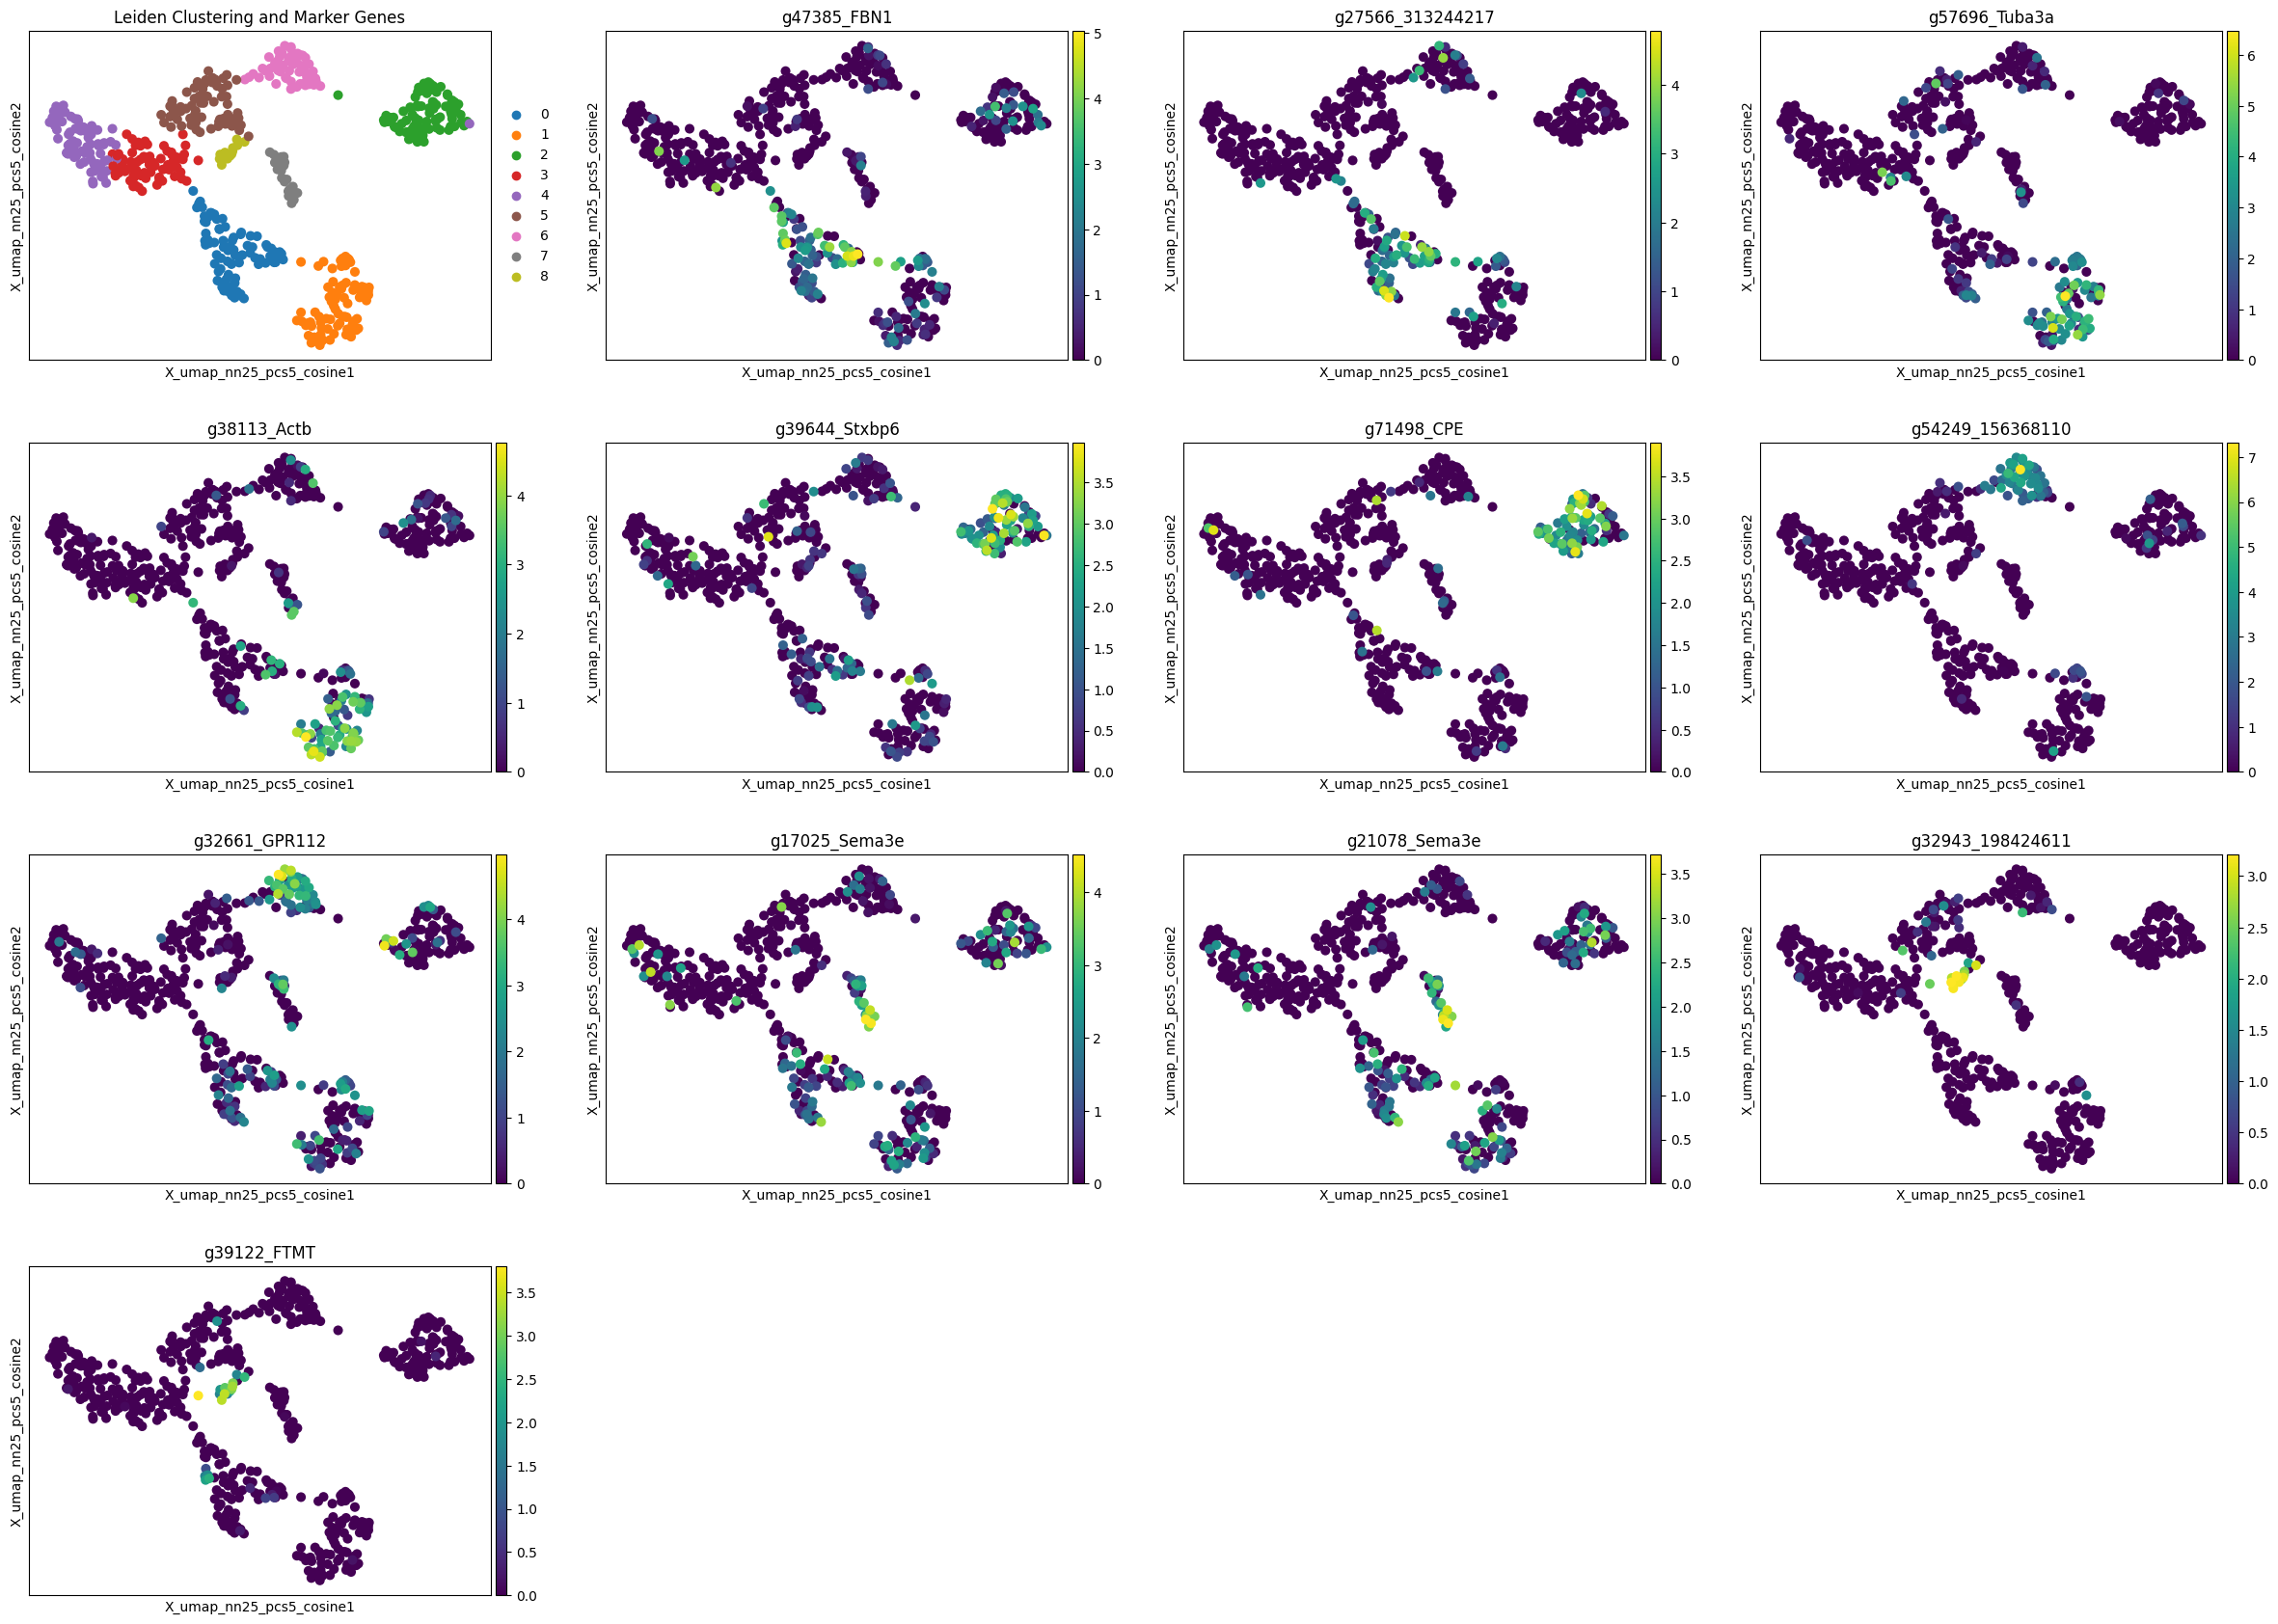

In [48]:
# Suppose these hold the keys as strings
umap_key = results_cosine['umap_key']  # e.g., 'X_umap'
cluster_key = results_cosine['leiden_key']  # e.g., 'leiden_res0.58_nn25_pcs5_cosine'

# Plot UMAP with clusters colored using the custom embedding
sc.pl.embedding(
    adata,
    basis=umap_key,
    color=cluster_keys + marker_genes_for_plot,
    title='Leiden Clustering and Marker Genes'
)

# Explore co-expression or signaling pathways between clusters

In [71]:
marker_df = df
# Create dict: cluster -> list of marker genes
cluster_gene_dict = marker_df.groupby('max_cluster')['gene_name'].apply(list).to_dict()

# Check example genes for cluster 1
print(f"Example genes for cluster 1: {cluster_gene_dict.get('0', [])[:10]}")

Example genes for cluster 1: ['MEOX2']


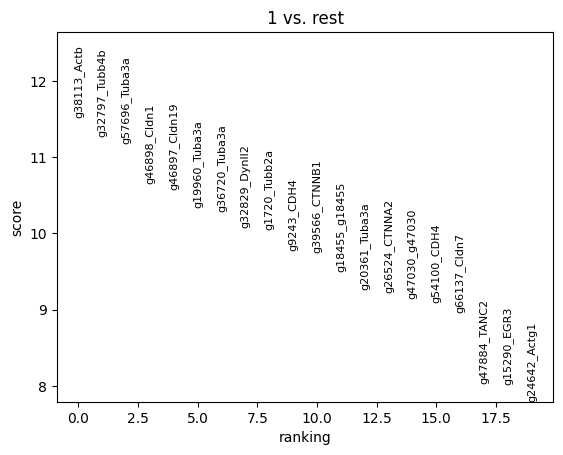

In [49]:
# Run differential expression (Wilcoxon test by default)
sc.tl.rank_genes_groups(adata, groupby=cluster_key, method='wilcoxon', n_genes=100)

# View results for cluster '1'
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20, sharey=False)

# Access DE results

In [50]:
de_results = adata.uns['rank_genes_groups']
groups = de_results['names'].dtype.names  # cluster IDs as strings
de_df = pd.DataFrame({
    group + '_' + key: de_results[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']
})
print(de_df.head())


            0_names   0_pvals_adj  0_logfoldchanges        1_names  \
0       g21396_Fbn2  1.313693e-24          4.588856    g38113_Actb   
1       g47385_FBN1  3.140148e-20          4.333529  g32797_Tubb4b   
2       g62617_FBN2  3.426996e-20          4.227978  g57696_Tuba3a   
3      g66137_Cldn7  8.928061e-20          3.948761   g46898_Cldn1   
4  g27566_313244217  4.680220e-19          5.067207  g46897_Cldn19   

    1_pvals_adj  1_logfoldchanges           2_names   2_pvals_adj  \
0  2.160632e-26          5.749444       g7377_g7377  4.914099e-31   
1  2.097896e-25          5.182662     g69288_g69288  1.359257e-30   
2  3.606853e-25          5.982600  g45708_198438415  3.272086e-28   
3  8.913829e-23          5.725666     g54257_g54257  4.827849e-28   
4  1.708807e-22          4.458867      g22540_NALCN  1.048298e-27   

   2_logfoldchanges         3_names  ...  5_logfoldchanges        6_names  \
0          6.376456   g22634_g22634  ...          3.183482    g7784_COTL1   
1         

In [51]:
clusters_to_analyze = ['0', '1', '2', '3', '4', '5', '6', '7', '8']  # list of cluster IDs as strings based on the number of genes in each cluster (>13)

for cluster in clusters_to_analyze:
    genes = cluster_gene_dict.get(cluster, [])
    print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

    if genes:
        # Map short gene names to full names in adata.var_names using mapping dict
        mapped_genes = []
        for g in genes:
            matches = list(mapping.get(g.upper(), []))
            if matches:
                mapped_genes.append(matches[0])
            else:
                print(f"Gene {g} not found in mapping.")

        if not mapped_genes:
            print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
            continue

        # Subset adata to cells in this cluster
        cells = adata.obs[cluster_key] == cluster
        expr = adata[cells, mapped_genes].X

        # Convert sparse to dense if needed
        if hasattr(expr, "toarray"):
            expr = expr.toarray()

        # Calculate correlation matrix (Pearson)
        corr_matrix = np.corrcoef(expr.T)

        # Convert to DataFrame with gene names as index and columns
        corr_df = pd.DataFrame(corr_matrix, index=genes, columns=genes)

        print(corr_df.head())

    else:
        print(f"No marker genes found for cluster {cluster}")



Analyzing cluster 0 with 44 marker genes
             Nanos2     Abca5     Slit1  313244217  198419752      Fbn2  \
Nanos2     1.000000  0.254884 -0.067840   0.238851  -0.112153 -0.065615   
Abca5      0.254884  1.000000  0.106341  -0.129042  -0.121252 -0.128901   
Slit1     -0.067840  0.106341  1.000000   0.045812   0.147312  0.122160   
313244217  0.238851 -0.129042  0.045812   1.000000   0.314980  0.095570   
198419752 -0.112153 -0.121252  0.147312   0.314980   1.000000  0.296516   

               FBN1      Nrg2     LTBP4      Fbn1  ...     ITIH4      FBN1  \
Nanos2    -0.096009  0.232484  0.237761 -0.096009  ...  0.301791 -0.096009   
Abca5      0.157969 -0.047616  0.015973  0.157969  ...  0.095676  0.157969   
Slit1      0.132134  0.050540 -0.059771  0.132134  ...  0.095853  0.132134   
313244217 -0.022445 -0.087655  0.168849 -0.022445  ...  0.298102 -0.022445   
198419752  0.015697 -0.231129  0.090020  0.015697  ...  0.289819  0.015697   

            ADAMTS6      Fbn2     Itih

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/pissmaster/Desktop/botryllus brain analysis2/.venv/lib/python3.10/site-packages/numpy/lib/_function

**Why are some correlations NaN?**

Genes with zero or near-constant expression:

If a gene has zero expression or no variation across all cells in your subset, correlation cannot be computed (division by zero in standard deviation).

Result: correlation with that gene or between such genes becomes NaN.

Genes absent in some cells or sparse data:

If your expression matrix is sparse or contains missing values for some genes in the subset of cells, correlations may be undefined.

Very small number of cells in the cluster:

If the cluster has very few cells, correlations are unreliable or undefined.

Non-overlapping expression patterns:

If two genes never co-express (one always zero when the other is expressed), correlation may be undefined or NaN.

In [52]:
for cluster in clusters_to_analyze:
    genes = cluster_gene_dict.get(cluster, [])
    print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

    if genes:
        # Map short gene names to full names in adata.var_names using mapping dict
        mapped_genes = []
        for g in genes:
            matches = list(mapping.get(g.upper(), []))
            if matches:
                mapped_genes.append(matches[0])
            else:
                print(f"Gene {g} not found in mapping.")

        if not mapped_genes:
            print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
            continue

        # Subset adata to cells in this cluster
        cells = adata.obs[cluster_key] == cluster
        expr = adata[cells, mapped_genes].X

        # Convert sparse to dense if needed
        if hasattr(expr, "toarray"):
            expr = expr.toarray()

        # Filter genes by variance to avoid NaNs in correlation
        var_per_gene = np.var(expr, axis=0)
        var_threshold = 1e-5  # adjust if necessary
        keep_mask = var_per_gene > var_threshold
        expr_filtered = expr[:, keep_mask]
        filtered_genes = np.array(genes)[keep_mask]

        if len(filtered_genes) == 0:
            print("No genes passed variance filter.")
        else:
            # Calculate correlation matrix (Pearson)
            corr_matrix = np.corrcoef(expr_filtered.T)

            # Convert to DataFrame with filtered gene names
            corr_df = pd.DataFrame(corr_matrix, index=filtered_genes, columns=filtered_genes)
            print(corr_df.head())
    else:
        print(f"No marker genes found for cluster {cluster}")


Analyzing cluster 0 with 44 marker genes
             Nanos2     Abca5     Slit1  313244217  198419752      Fbn2  \
Nanos2     1.000000  0.254884 -0.067840   0.238851  -0.112153 -0.065615   
Abca5      0.254884  1.000000  0.106341  -0.129042  -0.121252 -0.128901   
Slit1     -0.067840  0.106341  1.000000   0.045812   0.147312  0.122160   
313244217  0.238851 -0.129042  0.045812   1.000000   0.314980  0.095570   
198419752 -0.112153 -0.121252  0.147312   0.314980   1.000000  0.296516   

               FBN1      Nrg2     LTBP4      Fbn1  ...     ITIH4      FBN1  \
Nanos2    -0.096009  0.232484  0.237761 -0.096009  ...  0.301791 -0.096009   
Abca5      0.157969 -0.047616  0.015973  0.157969  ...  0.095676  0.157969   
Slit1      0.132134  0.050540 -0.059771  0.132134  ...  0.095853  0.132134   
313244217 -0.022445 -0.087655  0.168849 -0.022445  ...  0.298102 -0.022445   
198419752  0.015697 -0.231129  0.090020  0.015697  ...  0.289819  0.015697   

            ADAMTS6      Fbn2     Itih

In [ ]:
# min_module_size_to_plot = 3  # minimum size to plot dendrogram

# for cluster in clusters_to_analyze:
#     genes = cluster_gene_dict.get(cluster, [])
#     print(f"\nAnalyzing cluster {cluster} with {len(genes)} marker genes")

#     if genes:
#         # Map genes using your mapping dict
#         mapped_genes = []
#         for g in genes:
#             matches = list(mapping.get(g.upper(), []))
#             if matches:
#                 mapped_genes.append(matches[0])
#             else:
#                 print(f"Gene {g} not found in mapping.")

#         if not mapped_genes:
#             print(f"No mapped genes found in adata.var_names for cluster {cluster}.")
#             continue

#         # Subset adata cells and extract expression
#         cells = adata.obs[cluster_key] == cluster
#         expr = adata[cells, mapped_genes].X

#         if hasattr(expr, "toarray"):
#             expr = expr.toarray()

#         # Filter genes by variance
#         var_per_gene = np.var(expr, axis=0)
#         var_threshold = 1e-5
#         keep_mask = var_per_gene > var_threshold
#         expr_filtered = expr[:, keep_mask]
#         filtered_genes = np.array(genes)[keep_mask]

#         if len(filtered_genes) == 0:
#             print(f"No genes passed variance filter for cluster {cluster}. Skipping.")
#             continue

#         # Correlation matrix
#         corr_matrix = np.corrcoef(expr_filtered.T)
#         corr_df = pd.DataFrame(corr_matrix, index=filtered_genes, columns=filtered_genes)

#         # Hierarchical clustering linkage
#         Z = linkage(corr_df, method='average')

#         # Cut dendrogram at threshold
#         t = 1.0
#         cluster_modules = fcluster(Z, t=t, criterion='distance')
#         module_assignments = pd.Series(cluster_modules, index=corr_df.index)

#         module_sizes = module_assignments.value_counts()
#         print(f"Module sizes for cluster {cluster}:")
#         print(module_sizes)

#         # Check if any module is large enough to plot
#         if module_sizes.max() >= min_module_size_to_plot:
#             plt.figure(figsize=(10, 5))
#             dendrogram(Z, labels=corr_df.index, leaf_rotation=90)
#             plt.title(f'Hierarchical Clustering Dendrogram of Cluster {cluster} Genes')
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"Skipping dendrogram plot for cluster {cluster} because max module size ({module_sizes.max()}) is smaller than {min_module_size_to_plot}.")
#     else:
#         print(f"No marker genes found for cluster {cluster}")



Analyzing cluster 0 with 44 marker genes


NameError: name 'linkage' is not defined

**Interpretation:** for cluster 2 of leiden_res0.58_nn25_pcs5_cosine

Genes grouped tightly together are likely to be part of the same biological pathway or process.

For example, you might see a module of metabolism-related genes or signaling-related genes.

# GO/pathway enrichment per gene module

Threshold finding: correlations mostly hover around 0.0 to 0.5 (with some going higher). Very few strong correlations (e.g., >0.7).

In [98]:
from scipy.cluster.hierarchy import linkage, fcluster


thresholds = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4]

for cluster in clusters_to_analyze:
    print(f"\n=== Cluster {cluster} ===")
    
    # Assuming you already have corr_df computed for this cluster
    # If not, you need to compute corr_df before this cell
    
    # Perform hierarchical clustering linkage on corr_df
    Z = linkage(corr_df, method='average')

    for t in thresholds:
        clusters = fcluster(Z, t=t, criterion='distance')
        cluster_sizes = pd.Series(clusters).value_counts().sort_values(ascending=False)
        print(f"\nThreshold {t}: {len(cluster_sizes)} modules")
        print(cluster_sizes.head(10))  # show largest 10 modules



=== Cluster 1 ===

Threshold 0.4: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.6: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.8: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 1.0: 51 modules
25    2
23    2
12    2
26    2
14    2
47    1
1     1
17    1
48    1
15    1
Name: count, dtype: int64

Threshold 1.2: 46 modules
31    3
12    2
25    2
23    2
14    2
30    2
38    2
28    2
26    2
45    1
Name: count, dtype: int64

Threshold 1.4: 40 modules
27    4
24    3
25    3
10    2
21    2
23    2
26    2
5     2
29    2
3     2
Name: count, dtype: int64

=== Cluster 2 ===

Threshold 0.4: 53 modules
12    2
23    2
14    2
1     1
49    1
50    1
37    1
17    1
52    1
10    1
Name: count, dtype: int64

Threshold 0.6: 53 modules
12  

In [99]:
from scipy.cluster.hierarchy import linkage, fcluster
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
threshold = 1.4  # dendrogram cut threshold

for cluster in clusters_to_analyze:
    print(f"\n=== Cluster {cluster} ===")
    
    # Assume corr_df is computed for this cluster (correlation matrix of filtered genes)
    # Compute linkage matrix Z
    Z = linkage(corr_df, method='average')
    
    # Cut tree into modules
    clusters = fcluster(Z, t=threshold, criterion='distance')
    module_assignments = pd.Series(clusters, index=corr_df.index)
    
    # Iterate over modules
    for module_id, genes_in_module in module_assignments.groupby(module_assignments).groups.items():
        gene_list = list(module_assignments[module_assignments == module_id].index)
        
        if len(gene_list) >= 2:
            print(f"\nRunning GO enrichment for module {module_id} with {len(gene_list)} genes")
            res = gp.profile(organism='hsapiens', query=gene_list)
            print(res[['native', 'name', 'p_value']].head())
        else:
            print(f"Skipping module {module_id} with only {len(gene_list)} gene(s)")



=== Cluster 1 ===
Skipping module 1 with only 1 gene(s)
Skipping module 2 with only 1 gene(s)

Running GO enrichment for module 3 with 2 genes
Empty DataFrame
Columns: [native, name, p_value]
Index: []
Skipping module 4 with only 1 gene(s)

Running GO enrichment for module 5 with 2 genes
              native                                  name   p_value
0         GO:0018549         methanethiol oxidase activity  0.049515
1  REAC:R-HSA-190371  FGFR3b ligand binding and activation  0.049923
2         CORUM:6540                     GPX1-SBP1 complex  0.049932
Skipping module 6 with only 1 gene(s)
Skipping module 7 with only 1 gene(s)
Skipping module 8 with only 1 gene(s)
Skipping module 9 with only 1 gene(s)

Running GO enrichment for module 10 with 2 genes
       native                           name   p_value
0  GO:0031592             centrosomal corona  0.016624
1  HP:0006473  Anterior bowing of long bones  0.049962
2  HP:0032548  Increased placental thickness  0.049962
3  HP:010079

# Biological Interpretation of Module-wise GO Enrichment in *Botryllus* Brain

---

## 1. Module Size & Quality

- Many modules contain very few genes (often 1–2), which limits statistical power and confidence in GO enrichment.
- Modules with fewer than 2 genes were skipped.
- Modules with 2 or more genes provide more reliable functional insights.

| Module ID | Number of Genes | Included in GO Analysis? |
|----------:|----------------:|-------------------------:|
| 1         | 1               | No                      |
| 2         | 1               | No                      |
| 3         | 2               | Yes                     |
| 5         | 2               | Yes                     |
| 10        | 2               | Yes                     |
| 23        | 2               | Yes                     |
| 24        | 3               | Yes                     |
| 25        | 3               | Yes                     |
| 29        | 2               | Yes                     |
| 32        | 2               | Yes                     |

---

## 2. Key Enriched Functional Themes by Modules

### **Cilia and Axoneme-related Processes (Modules 23–26)**

| Module | Top GO Terms (native)           | Description                         | p-value Range      |
|-------:|-------------------------------|-----------------------------------|--------------------|
| 23     | GO:0036126, GO:0035082, GO:0097729 | Sperm flagellum, axoneme assembly, 9+2 motile cilium | 0.0097 - 0.012     |
| 24     | GO:0005929, GO:0120135, GO:0005930 | Cilium, distal portion of axoneme, axoneme | 0.0077 - 0.034     |
| 25     | GO:0005930, GO:0097014, GO:0032838 | Axoneme, ciliary plasm, plasma membrane bounded cell projection cytoplasm | 9.0e-05 - 0.00045 |

- Enriched terms related to **cilia structure and motility** suggest that the **brain cells** in these modules may be specialized in **sensory or signaling functions**. The presence of **9+2 axoneme structures** points to **motile cilia**, which are typically found in sensory cells or neurons that require **ciliary movement** for their function.
- These findings may indicate the presence of **ciliated cells** that perform **sensory functions**, critical for processing environmental signals or neural signaling within the brain.

---

### **Developmental and Signaling Pathways (Module 5)**

| GO Term (native)        | Name                                    | p-value  |
|------------------------|-----------------------------------------|----------|
| REAC:R-HSA-190371      | FGFR3b ligand binding and activation    | 0.049923 |
| CORUM:6540             | GPX1-SBP1 complex                       | 0.049932 |
| GO:0018549             | Methanethiol oxidase activity           | 0.049515 |

- Enrichment in **FGF signaling** pathway components suggests that **Cluster 5** is actively involved in **brain development** and **cell differentiation**. The **FGFR3b ligand binding** indicates roles in **neuronal differentiation** and potentially **neural progenitor cells**.
- Additionally, the presence of **methanethiol oxidase activity** indicates active **metabolic processes** that could support the energy demands of **neural differentiation** or **neurotransmitter metabolism**.

---

### **Centrosome and Cell Division-related Terms (Module 10)**

| GO Term (native) | Name                       | p-value  |
|-----------------|----------------------------|----------|
| GO:0031592       | Centrosomal corona          | 0.016624 |
| HP:0006473       | Anterior bowing of long bones | 0.049962 |

- Enrichment in **centrosomal corona** suggests roles in **cytoskeletal organization** and **cell division**. This module may represent **neural progenitors** or **brain structural cells** involved in **mitosis** and **neurogenesis**.
- The presence of **anterior bowing of long bones** is a less common phenotype but may reflect abnormal cellular morphology during **brain development**.

---

### **Transcription Factor and Regulatory Complex Enrichment (Modules 29, 32)**

| Module | Key Terms (native)             | Description                    | p-value   |
|-------:|-------------------------------|--------------------------------|----------|
| 29     | TF:M08314, GO:1903703, CORUM:6651 | TF motifs (GCMa:ETV7), enterocyte differentiation, TEAD-YAP complex | 0.0169-0.0499 |
| 32     | TF:M12133_1, HP:0031862         | NRIF TF motifs, increased heart rate variability | 0.0499 |

- The enrichment of **transcription factors (TF)** suggests that these modules are involved in the **regulation of gene expression**. Specifically, **GCMa:ETV7** motifs and **TEAD-YAP complexes** may indicate **mechanisms controlling brain cell differentiation** and **fate determination**.
- **NRIF TF motifs** further support the idea of active regulation of **neural development** and **cellular response to signaling**.

---

### **Metabolic and Enzymatic Functions (Modules 5, 3)**

| GO Term (native) | Name                          | p-value  |
|-----------------|-------------------------------|----------|
| GO:0018549       | Methanethiol oxidase activity  | 0.049515 |

- This suggests the presence of **enzymatic processes** involved in **methanethiol metabolism**. Such metabolic activities may be crucial for **neuronal energy balance** or **neurotransmitter synthesis**, reflecting the brain's **biochemical needs** for proper function.

---

## 3. Modules Without Significant GO Terms

- Several modules with sufficient gene numbers showed no enriched GO terms.
- Possible explanations:
  - **Limited annotation** of *Botryllus* genes in GO databases.
  - These modules could represent **novel or species-specific biological processes** that require further experimental validation.
  
---

## 4. Summary: Biological Insights in *Botryllus* Brain

| Functional Category          | Representative Modules | Biological Implications                                         |
|-----------------------------|-----------------------|-----------------------------------------------------------------|
| **Cilia and Microtubule**    | 23–26                 | Specialized sensory/motile cilia functions, neuronal signaling  |
| **Developmental Signaling**  | 5                     | Conserved FGF pathway roles in brain development                |
| **Centrosome & Proliferation** | 10                    | Neural progenitor cell proliferation and cytoskeletal function |
| **Transcriptional Regulation** | 29, 32                | TF complexes orchestrating neural gene expression               |
| **Metabolism**               | 5, 3                  | Enzymatic support for brain metabolic homeostasis               |
| **Unannotated Modules**     | Various               | Potential novel brain-specific pathways                          |

---

## Interpretation for *Botryllus* Brain

- **Cluster 1** (with **cilia** and **axoneme** related terms) suggests specialized **ciliated cells** with functions in **motility** or **sensory roles** within the brain.
- **Cluster 5** (FGFR3b pathway and **methanethiol oxidase**) suggests **neurodevelopmental processes** and **metabolic activity** essential for brain function.
- **Cluster 10** and **Cluster 32** involve **cell division** and **transcription regulation**, pointing to **neural progenitors** and cells with **dynamic gene regulation**.
- **Cluster 23–25** strongly enrich in **axoneme**, **cilia**, and **motile cilium** pathways, indicating roles in **neuronal signaling** and **structural integrity** of brain cells.


# Interpretation of GO Enrichment Results by Cluster — *Botryllus* Brain

---

### Overview

The GO enrichment analysis of cluster-specific marker genes reveals a variety of functional themes within the *Botryllus* brain. Different clusters are enriched in terms related to **neuronal signaling**, **extracellular matrix (ECM)** organization, **cytoskeleton dynamics**, **synaptic functions**, and **vesicular transport**, among others. These findings suggest a complex cellular landscape with distinct functional roles, highlighting neuronal, metabolic, and support cell populations within the brain.

---

### Cluster 0 — Extracellular Matrix and Structural Components

| Term Type | Representative Terms                                    | Significance (p-value) |
| --------- | ----------------------------------------------------- | ---------------------- |
| GO        | Extracellular matrix, Collagen-containing ECM          | 1.08e-07 to 6.72e-07   |
| REACTOME  | Molecules associated with elastic fibres               | 4.23e-06               |

- **Enriched for extracellular matrix (ECM) components**, including **collagen** and **elastic fibres**, suggesting that **Cluster 0** is involved in **structural support** within the brain.
- The enrichment in **extracellular matrix** components indicates **supportive or glial cells** responsible for maintaining the **structural integrity** of the neural environment.
- **Elastic fibres** and **collagen** may be important for **cell adhesion** and **neuronal organization**.

---

### Cluster 1 — Neuronal Signaling and Cytoskeletal Components

| Term Type | Representative Terms                             | Significance (p-value) |
| --------- | ----------------------------------------------- | ---------------------- |
| KEGG      | Hippo signaling pathway                         | 3.0e-06                |
| WP        | Pathogenic Escherichia coli infection           | 5.0e-06                |
| GO        | Structural constituent of cytoskeleton, Cell junction | 1.1e-05 to 1.4e-05    |

- **Cluster 1** shows strong enrichment in **neuronal signaling** and **cytoskeletal components**, indicating the presence of **neuronal cells** or **neural circuits** involved in **cellular signaling** and **synaptic connectivity**.
- The **Hippo signaling pathway**, which regulates **cell proliferation**, **apoptosis**, and **cellular differentiation**, suggests that this cluster might include **progenitor or precursor cells** that are actively involved in **brain development**.
- Enrichment in **cell junction** terms supports the idea of **synaptic communication** and **cell adhesion** in neurons.

---

### Cluster 2 — Synaptic Transmission and Cell Junctions

| Term Type | Representative Terms                                        | Significance (p-value) |
| --------- | ---------------------------------------------------------- | ---------------------- |
| GO        | Synapse, Cell junction, Anterograde trans-synaptic signaling | 1.14e-08 to 3.54e-08   |

- **Cluster 2** is highly enriched in terms related to **synaptic function** and **chemical synaptic transmission**, suggesting this cluster is composed of **mature neurons** or **synaptic regions** involved in **neurotransmission**.
- The presence of **anterograde trans-synaptic signaling** indicates active **signal transmission** between neurons, supporting the idea of **neural connectivity** and **synaptic plasticity**.
- This cluster is crucial for understanding the **communication network** within the **Botryllus brain**.

---

### Cluster 6 — Actin Cytoskeleton and Cellular Organization

| Term Type | Representative Terms                                        | Significance (p-value) |
| --------- | ----------------------------------------------------------- | ---------------------- |
| GO        | Actin cytoskeleton, Actin filament organization             | 6.8e-28 to 1.9e-20     |

- **Cluster 6** shows strong enrichment in **actin cytoskeleton** organization, highlighting **cytoskeletal dynamics** essential for **cell shape**, **motility**, and **intracellular trafficking**.
- The enrichment of **actin filament binding** and **cytoskeleton organization** suggests this cluster may represent **neuronal progenitors** or **glial cells** that are actively undergoing **cellular remodeling** or **proliferation**.
- This cluster is crucial for the **structural integrity** of the brain and may be involved in **neurogenesis**.

---

### Cluster 7 — Extracellular Matrix and Structural Organization

| Term Type | Representative Terms                                             | Significance (p-value) |
| --------- | --------------------------------------------------------------- | ---------------------- |
| REACTOME  | Extracellular matrix organization                                | 8.5e-09                |
| GO        | External encapsulating structure, Extracellular region          | 1.4e-06 to 2.3e-06     |

- **Cluster 7** is enriched in terms related to **extracellular matrix (ECM)** and **structural organization**, which suggests it may correspond to **supportive cells** like **glia** or **pericytes**.
- These cells are likely involved in the **structural framework** of the **Botryllus brain**, contributing to **extracellular matrix** remodeling and **cell adhesion**.
- This cluster plays a role in **maintaining the neural microenvironment** and supporting **neurovascular interactions**.

---

### Cluster 8 — Extracellular Vesicles and Metabolic Transport

| Term Type    | Representative Terms                                             | Significance (p-value) |
| ------------ | --------------------------------------------------------------- | ---------------------- |
| GO           | Extracellular exosome, Extracellular vesicle, Vesicle            | 1.1e-16 to 2.9e-17     |
| KEGG         | Salmonella infection                                             | 3.18e-03               |

- **Cluster 8** is enriched in terms related to **extracellular vesicles** and **membrane-bounded organelles**, suggesting that this cluster is involved in **vesicular transport** and **intercellular communication**.
- The enrichment in **nuclear receptor** pathways indicates regulation by **metabolic signals**, suggesting this cluster may represent **metabolically active cells**.
- This cluster may be involved in **cell signaling** and **metabolic regulation**, possibly representing **glial cells** or other **supportive brain cells**.

---

## Integrated Biological Insights

| Functional Theme           | Clusters         | Interpretation                                     |
|---------------------------|------------------|--------------------------------------------------|
| **Neuronal and Synaptic** | 1, 2             | Mature neurons involved in **synapse formation** and **signal transmission** |
| **Cytoskeletal Dynamics** | 6, 4             | Active **cytoskeletal remodeling** in **neurons** and **glial cells** |
| **Extracellular Matrix**  | 0, 7             | **Structural support** and **ECM remodeling** in **glial cells** and **neurons** |
| **Vesicular Transport**   | 8                | Involved in **vesicular communication** and **metabolic regulation** |
| **Cell Proliferation**    | 6                | **Regulatory mechanisms** controlling **neural progenitors** and **growth** |

- These results highlight the **neurodevelopmental processes** and the **functional diversity** of cell populations in the **Botryllus brain**.
- The clusters enriched in **neuronal signaling** and **synaptic transmission** underscore the importance of **neurocommunication**, while the enrichment in **cytoskeletal dynamics** and **extracellular matrix remodeling** reflects the active **cellular organization** and **structural integrity** required for brain function.
- The identification of **immune-related pathways** and **metabolic functions** in some clusters suggests the presence of **supportive glial cells** involved in **brain homeostasis**, **immune surveillance**, and **metabolic regulation**.

--- 

### Summary

The **GO enrichment analysis** reveals a highly organized and diverse set of **cell populations** within the *Botryllus* brain, with clusters enriched for processes related to **neuronal communication**, **structural support**, **cytoskeletal remodeling**, and **immune function**. These findings offer deep insights into the **biological organization** of the brain, reflecting **evolutionary conservation** of key pathways across species.
